In [259]:
import csv
import os
import numpy as np
from matplotlib import pyplot
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import datetime as dt
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

## グラフの設定

In [260]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 9 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 10 # 軸だけ変更されます
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make grid
plt.rcParams["legend.fancybox"] = False # 丸角
plt.rcParams["legend.framealpha"] = 1 # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black' # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1 # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0. # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 1. # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 2 # 点がある場合のmarker scale
# 数式はtex形式で
# r+$マークで囲いましょう。
# https://matplotlib.org/users/mathtext.html が参考になります。
# fig_1.set_xlabel(r"$x$")
# fig_1.set_ylabel(r"$y$")
# また、よくある軸を共有するやつは以下の感じでできます。
# 軸を共有させたい
# other_fig_1 = fig_1.twinx()
# other_fig_1.plot(x, y_2, label="test_2") # y_2は適当に作成したものです
# other_fig_1.set_ylabel(r"$y_{2}$")
# 軸の数字を斜めにする
# もできます。
# 以下コードを追加してください。
# fig_1.set_xticklabels(np.round(x, 2), rotation=30)

## データの読み込み、整理

In [287]:
#read a file
#インデックスをTIMESTANPに設定し，時系列データとして読み込む(index_col='TIMESTAMP', parse_dates=True)
df01 = pd.read_csv('logger1_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df02 = pd.read_csv('logger2_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df03 = pd.read_csv('logger3_2018-03-20_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df04 = pd.read_csv('Precipitation_WL_Velocity201801to201812_every_1min.csv', index_col='TIMESTAMP', parse_dates=True)
# print(df01,df02,df03,df04)

#read 2017file
df_2017 = pd.read_csv('Fukadani201607to201711.csv', index_col='TIMESTAMP', parse_dates=True)

In [262]:
df_all = pd.concat([df01, df02, df03, df04], axis=1,sort=False)

#Load_Avgの差分をとる
df_all['Load_Avg_difference'] = df_all['Load_Avg'].diff()
df_2017['Load_Avg_difference'] = df_2017['Load_Avg'].diff()

# #NaNデータを削除
# df_all = df_all.dropna(how='any')

In [263]:
#縦横補正する
h, hp, l = 1, 1, 1

for i in range(1,11):
    df_all['Rhv_right_Tot({})'.format(i)] = (df_all['VR_Tot({})'.format(i)]/h)/(df_all['R_Tot({})'.format(i)]/l)
    df_all['Rhv_left_Tot({})'.format(i)] = (df_all['VL_Tot({})'.format(i)]/h)/(df_all['L_Tot({})'.format(i)]/l)
    
    df_all['Corrected_with_right_Tot({})'.format(i)] = df_all['Rhv_right_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]
    df_all['Corrected_with_left_Tot({})'.format(i)] = df_all['Rhv_left_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]

# for i in range(1,11):
#     df_2017['Rhv_right_Tot({})'.format(i)] = (df_2017['VR_Tot({})'.format(i)]/h)/(df_2017['R_Tot({})'.format(i)]/l)
#     df_2017['Rhv_left_Tot({})'.format(i)] = (df_2017['VL_Tot({})'.format(i)]/h)/(df_2017['L_Tot({})'.format(i)]/l)
    
#     df_2017['Corrected_with_right_Tot({})'.format(i)] = df_2017['Rhv_right_Tot({})'.format(i)]*h/hp*df_2017['C_Tot({})'.format(i)]
#     df_2017['Corrected_with_left_Tot({})'.format(i)] = df_2017['Rhv_left_Tot({})'.format(i)]*h/hp*df_2017['C_Tot({})'.format(i)]   

In [264]:
#name[1]にはスロット１のデータ、name[2]には、スロット２のデータ、name[3]に、、、が入っている
names = [0]*10
for j in range(1,11):
    names[j-1] = [i for i in df_all.columns if '({})'.format(j) in i]
    
#Rhv_right_TotとCorrected_with_right_Totを削除
for i, name in enumerate(names):
    names[i] = name[:-4]

#（スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）、、、としていき、
#粒径ごとのデータに分類する
df_dia_2018 = [0]*9
for i in range(1,10):
    df_dia_2018[i-1] = df_all[names[i-1]] - df_all[names[i]].values

#全てのデータを繋げる
df_dia_all_2018 = pd.DataFrame()
for i in range(1,10):
    df_dia_all_2018 = pd.concat([df_dia_all_2018, df_dia_2018[i-1]], axis=1 )

df_dia_all_2018['Load_Avg'] = df_all['Load_Avg']
df_dia_all_2018['Load_Avg_difference'] = df_all['Load_Avg_difference']

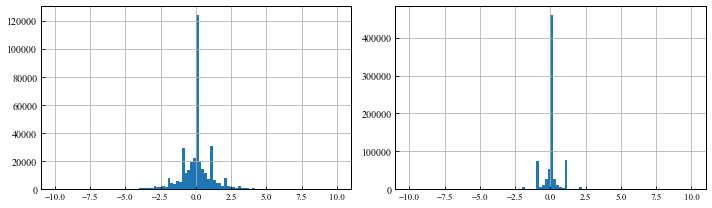

In [265]:
def histgram_of_Load_Avg_difference(df, num_bins=100, nums_range=(-10,10)):
    # グラフが見きれないようにするためサイズを大きくしておく
    rcParams['figure.figsize'] = 5, 5
    # ヒストグラムを描画する(一括の時は単純にdf.hist())
    df['Load_Avg_difference'].hist(bins=num_bins,range=nums_range)

%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
histgram_of_Load_Avg_difference(df_all)
plt.subplot(122)
histgram_of_Load_Avg_difference(df_2017)
# グラフ同士が重ならないようにする関数
plt.tight_layout()

Text(0, 0.5, 'Pit weight[kg]')

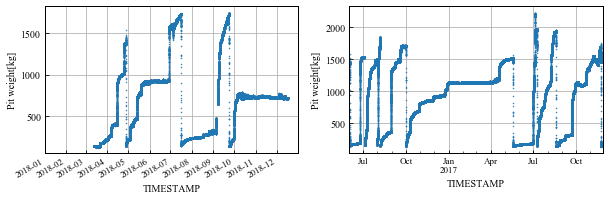

In [266]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplot(121)
df_all['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')


Text(0, 0.5, 'Pit weight[kg]')

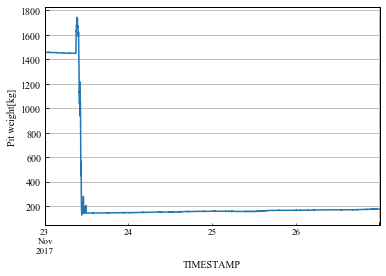

In [267]:
%matplotlib inline
df_2017['Load_Avg']["2017-11-23 0:00":"2017-12-24 0:00"].plot()
plt.ylabel('Pit weight[kg]')

In [268]:
# #イベント
# df_2017['Load_Avg']["2016-6-25 0:00":"2016-6-25 12:00"]
# df_2017['Load_Avg']["2016-7-05 0:00":"2016-7-30 0:00"]
# df_2017['Load_Avg']["2016-7-31 0:00":"2016-8-4 0:00"]
# df_2017['Load_Avg']["2016-8-30 5:00":"2016-8-30 20:00"]
# df_2017['Load_Avg']["2016-10-2 0:00":"2016-10-30 0:00"]
# df_2017['Load_Avg']["2016-12-12 0:00":"2016-12-29 0:00"]
# df_2017['Load_Avg']["2017-7-01 0:00":"2017-7-02 0:00"]
# df_2017['Load_Avg']["2017-7-09 0:00":"2017-8-8 0:00"]
# df_2017['Load_Avg']["2017-9-22 0:00":"2017-10-3 0:00"]
# df_2017['Load_Avg']["2017-10-22 12:00":"2017-10-23 12:00"]

# #除外イベント
# df_2017['Load_Avg']["2016-10-1 0:00":"2016-10-2 0:00"]
# df_2017['Load_Avg']["2017-11-23 0:00":"2017-11-24 0:00"]

In [269]:
#2018年データの整理
#4/28、7/26 9/4-6 9/23にピット掃除をしていそうだったのでデータを全部削除
#データに異常がみられる3/26,4/18を削除
#イベントがなく、じわじわピット内流砂が減少していた10/4以降を削除
sidxs = []
eidxs = []

sidxs.append('2018-04-28 0:00')
eidxs.append('2018-04-29 0:00')

sidxs.append('2018-07-16 0:00')
eidxs.append('2018-07-17 0:00')

sidxs.append('2018-09-04 0:00')
eidxs.append('2018-09-06 0:00')

sidxs.append('2018-09-23 0:00')
eidxs.append('2018-09-24 0:00')

sidxs.append('2018-03-26 0:00')
eidxs.append('2018-03-27 0:00')

sidxs.append('2018-04-18 0:00')
eidxs.append('2018-04-19 0:00')

sidxs.append('2018-10-04 0:00')
eidxs.append(df_all.index[-1])



for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_all.index
    df_all = df_all.drop(drop_date_range)
    #
    df_dia_all_2018 = df_dia_all_2018.drop(drop_date_range)
        



#ピット差分が１０以上で、水平ハイドロフォンの６４倍が０のデータは全て消しました。
df_all = df_all[~((df_all['Load_Avg_difference'] >= 10)&(df_all['hp_Tot(6)'] <= 3))]
#
df_dia_all_2018 = df_dia_all_2018[~((df_dia_all_2018['Load_Avg_difference'] >= 10)&(df_dia_all_2018['hp_Tot(6)'] <= 3))]

In [270]:
#２０１７年データの整理
#ピット掃除をしていそうだったのでデータを全部削除
sidxs = []
eidxs = []

sidxs.append("2016-10-1 0:00")
eidxs.append('2016-10-2 0:00')

sidxs.append("2017-11-23 0:00")
eidxs.append('2017-12-24 0:00')

# sidxs.append('2018-10-04 0:00')
# eidxs.append(df_all.index[-1])



for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_2017.index
    df_2017 = df_2017.drop(drop_date_range)

#Cut data where pit weigh < 1000?500?
df_2017['Load_Avg'] = df_2017['Load_Avg'].values.astype('float')
# df_2017 = df_2017[(df_2017['Load_Avg'] > 200)&(df_2017['Load_Avg'] < 1300)]

# Cut data where pit load difference is out of margin of error
df_2017 = df_2017[(df_2017['Load_Avg_difference'] < 20)&(df_2017['Load_Avg_difference'] > -0.5)]

df_2017 = df_2017[~((df_2017['Load_Avg_difference'] > 5)&(df_2017['hp_Tot(6)'] < 50))]

#ピット差分が１０以上で、水平ハイドロフォンの６４倍が1０以下のデータは全て消しました。
df_2017 = df_2017[~((df_2017['Load_Avg_difference'] >= 10)&(df_2017['hp_Tot(6)'] <= 10))]

Text(0, 0.5, 'Pit weight[kg]')

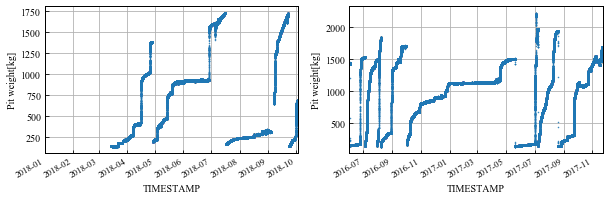

In [271]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
df_all['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')

In [272]:
sum_interval = 30

df_sum_2018 = df_all.resample('{}T'.format(sum_interval)).sum() / sum_interval
df_sum_2018['Load_Avg'] = df_all['Load_Avg']
df_sum_2018['Load_Avg_difference'] = df_all['Load_Avg_difference'].resample('{}T'.format(sum_interval)).sum()/ sum_interval

df_sum_2017 = df_2017.resample('{}T'.format(sum_interval)).sum() / sum_interval
df_sum_2017['Load_Avg'] = df_2017['Load_Avg']
df_sum_2017['Load_Avg_difference'] = df_2017['Load_Avg_difference'].resample('{}T'.format(sum_interval)).sum()/ sum_interval

df_sum_dia_2018 = df_dia_all_2018.resample('{}T'.format(sum_interval)).sum() / sum_interval
df_sum_dia_2018['Load_Avg'] = df_dia_all_2018['Load_Avg']
df_sum_dia_2018['Load_Avg_difference'] = df_dia_all_2018['Load_Avg_difference'].resample('{}T'.format(sum_interval)).sum()/ sum_interval
# mavgs = 3
# temp_X_cols = df1[X_cols].rolling(window=mavgs).mean()
# temp_y_cols = df1[y_cols].rolling(window=mavgs).mean()


# df1.dropna(how='any')


Text(0, 0.5, 'Pit weight[kg]')

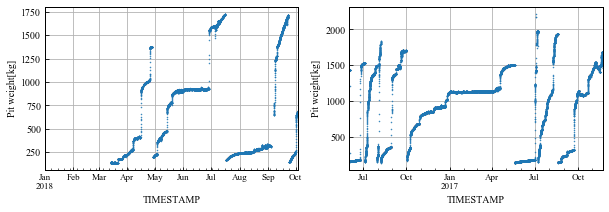

In [273]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
df_sum_2018['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_sum_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')

In [274]:
# moving averages
#Setting a rate of moving averages
mavgs = 3
df_movingav_2018 = df_all.rolling(mavgs).mean()
# # NaNデータを削除
# df_movingav_2018 = df_movingav_2018.dropna(how='any')


df_movingav_2017 = df_2017.rolling(mavgs).mean()
# # NaNデータを削除
# df_movingav_2017 = df_movingav_2017.dropna(how='any')

## データの切り替え

In [288]:
#使うデータを切り替える（sumなのか、moving averageなのか、２０１７年なのか２０１８年なのか）
#####################
# year = "2017"
year = "2018"
process = "sum"
# process = "sum_dia"
# process = "movingav"
#####################
list_of_processes = ["df_movingav_2017", "df_movingav_2018", "df_sum_2017", "df_sum_2018", "df_sum_dia_2018"]

#使うデータを絞り込む
list_name = [s for s in list_of_processes if year in s]
print(list_name)
list_name= [s for s in list_name if process in s]
print(list_name)
#使うデータをdf_finと名付けて以下使う
df_fin = eval(list_name[0])

['df_movingav_2018', 'df_sum_2018', 'df_sum_dia_2018']
['df_sum_2018', 'df_sum_dia_2018']


## ピット内重量ごとにデータを分けてグラフを描く

In [289]:
def cut_by_pit_value(x, y, df):
    
    '''
    x：ピットの下限
    y：ピットの上限
    df：df_finを入れればいい

    ピット内重量がx以上y以下のデータのみを取り出す
    '''
    df_cut = df[(df['Load_Avg'] > x)&(df['Load_Avg'] < y)]
    return df_cut

In [290]:
#ピット内が０～２００kg,２００～４００kg,２００～４００kg.......１４００～１６００kgの時を取り出す
df_fin_cut = [0]*8
for i in range(len(df_fin_cut)):
    df_fin_cut[i] = cut_by_pit_value(i*200, (i+1)*200, df_fin)

In [291]:
print(df_fin.columns)

Index(['Unnamed: 0', 'RECORD', 'Bat_Avg', 'Pit_WL_Avg', 'L_UR_Avg', 'L_UL_Avg',
       'L_DR_Avg', 'L_DL_Avg', 'Load_Avg', 'WL_FMR_Avg',
       ...
       'Corrected_with_right_Tot(8)', 'Corrected_with_left_Tot(8)',
       'Rhv_right_Tot(9)', 'Rhv_left_Tot(9)', 'Corrected_with_right_Tot(9)',
       'Corrected_with_left_Tot(9)', 'Rhv_right_Tot(10)', 'Rhv_left_Tot(10)',
       'Corrected_with_right_Tot(10)', 'Corrected_with_left_Tot(10)'],
      dtype='object', length=185)


In [292]:
#スロットナンバーと倍率を対応させる
amplification_factor = {'hp_Tot(1)':'1024', 'hp_Tot(2)':'512', 'hp_Tot(3)':'256','hp_Tot(4)':'128',
                        'hp_Tot(5)':'64','hp_Tot(6)':'32','hp_Tot(7)':'16','hp_Tot(8)':'8',
                        'hp_Tot(9)':'4','hp_Tot(10)':'2'}

In [293]:
def make_graphs_from_1to10():
    if process == "sum_dia":
        range_max = 9
    else:
        range_max = 11
    num_of_amplification = None
    for i in range(1,range_max):
        x_name = "Load_Avg_difference"
        y_name = "hp_Tot({})".format(i)
        num_of_amplification = amplification_factor[y_name]
        #ファイルの保存先
        save_dir = './scatter_gparhs_by_pit_fill_rate/' 
        # max(max(nums1, nums2, key=max))
        %matplotlib inline
        ylim = max(df_fin_cut[0][y_name].max(),df_fin_cut[1][y_name].max(), df_fin_cut[2][y_name].max(),
                     df_fin_cut[3][y_name].max(),df_fin_cut[4][y_name].max())
        xlim = max(df_fin_cut[0][x_name].max(),df_fin_cut[1][x_name].max(), df_fin_cut[2][x_name].max(),
                     df_fin_cut[3][x_name].max(),df_fin_cut[4][x_name].max())
        margin = ylim/20
        
        print(ylim,xlim,margin)

        fig = plt.figure(figsize=(10, 10))
        for i in range(len(df_fin_cut)):
            x = df_fin_cut[i][x_name]
            y = df_fin_cut[i][y_name]
            plt.subplot(331 + i)
            plt.title("{0}to{1}".format(i*200, (i+1)*200))
            plt.scatter(x, y, marker='.')
            plt.xlim(-1,xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg min-1]')

        plt.subplot(339)
        plt.title("200-1200")
        for i in range(1,6):
            x = df_fin_cut[i][x_name]
            y = df_fin_cut[i][y_name]
            plt.scatter(x, y, marker='.')
            plt.xlim(-1,xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg min-1]')

        fig.tight_layout()
        #名前をつけて保存
        plt.savefig(os.path.join(save_dir, y_name + year + "_" + process), bbox_inches="tight", pad_inches=0.05)

569.7 2.773333333333331 28.485000000000003
511.6333333333333 2.773333333333331 25.581666666666667
411.8333333333333 2.773333333333331 20.591666666666665
298.6333333333333 2.773333333333331 14.931666666666667
243.2 2.773333333333331 12.16
169.46666666666667 2.773333333333331 8.473333333333333
120.7 2.773333333333331 6.035
77.23333333333333 2.773333333333331 3.861666666666667
42.86666666666667 2.773333333333331 2.1433333333333335
14.4 2.773333333333331 0.72


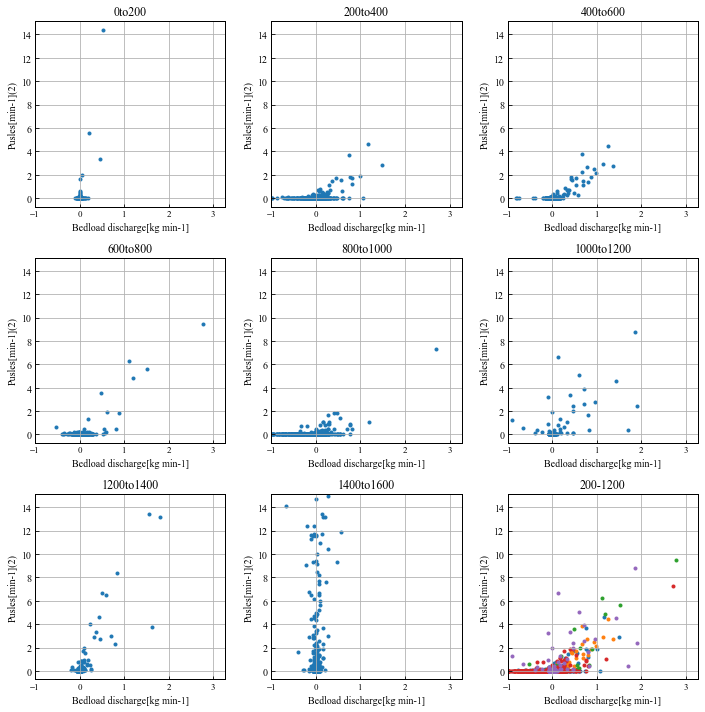

In [294]:
make_graphs_from_1to10()

In [282]:
#使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"

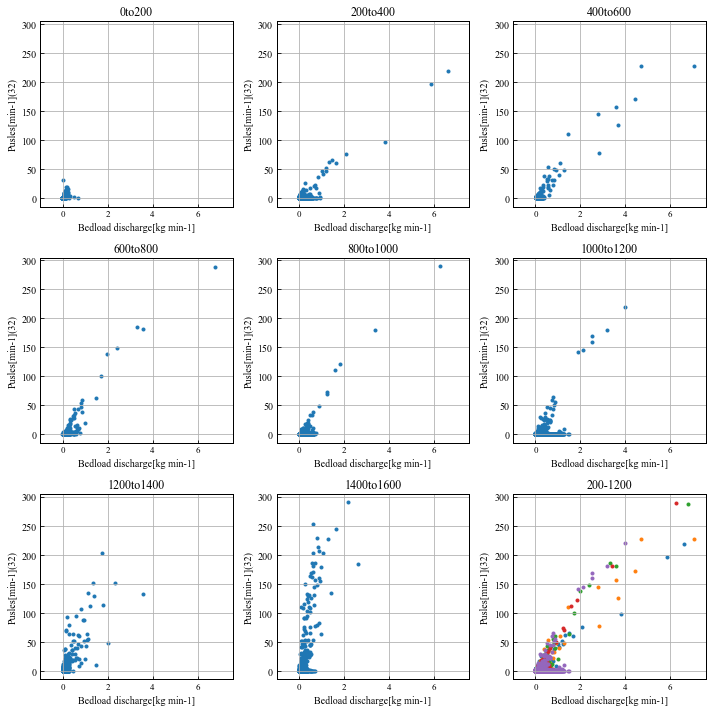

In [283]:
#ファイルの保存先
save_dir = './scatter_gparhs_by_pit_fill_rate/' 
num_of_amplification = amplification_factor[y_name]

%matplotlib inline
ylim = max(df_fin_cut[0][y_name].max(),df_fin_cut[1][y_name].max(), df_fin_cut[2][y_name].max(),
             df_fin_cut[3][y_name].max(),df_fin_cut[4][y_name].max())
xlim = max(df_fin_cut[0][x_name].max(),df_fin_cut[1][x_name].max(), df_fin_cut[2][x_name].max(),
             df_fin_cut[3][x_name].max(),df_fin_cut[4][x_name].max())
margin = ylim/20

fig = plt.figure(figsize=(10, 10))
# plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
# plt.xlabel('Bedload discharge[kg m-1min-1]')
for i in range(len(df_fin_cut)):
    x = df_fin_cut[i][x_name]
    y = df_fin_cut[i][y_name]
    plt.subplot(331 + i)
    plt.title("{0}to{1}".format(i*200, (i+1)*200))
    plt.scatter(x, y, marker='.')
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')

plt.subplot(339)
plt.title("200-1200")
for i in range(1,6):
    x = df_fin_cut[i][x_name]
    y = df_fin_cut[i][y_name]
    plt.scatter(x, y, marker='.')
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')


fig.tight_layout()
#名前をつけて保存
plt.savefig(os.path.join(save_dir, y_name + year + "_" + process), bbox_inches="tight", pad_inches=0.05)

## イベントごとに抽出して分布図を見る

In [284]:
df_event_num = [0]*5
if year == "2018":
    df_event_num = [0]*5
    #event No. 1: 2018年4月15日 0:00－16日 0:00  24h
    #event No. 2: 2018年4月24日18:00－25日18:00  24h
    #event No. 3: 2018年6月28日 6:00－28日18:00  12h
    #event No. 4: 2018年9月 8日 0:00－16日12:00  372h
    #event No. 5: 2018年9月30日21:00－10月1日3:00 6h
    df_event_num[0] = df_fin['2018-04-15 0:00' : '2018-04-16 0:00']
    df_event_num[1] = df_fin['2018-04-24 18:00' : '2018-04-25 18:00']
    df_event_num[2] = df_fin['2018-06-28 6:00' : '2018-06-28 18:00']
    df_event_num[3] = df_fin['2018-09-08 0:00' : '2018-09-16 12:00']
    df_event_num[4] = df_fin['2018-09-30 21:00' : '2018-10-1 6:00']
    # #df_event_no5['Rhv_right_Tot(5)']になぜかinfやNanがあり、あとでグラフが書けなくなったからとりあえず０で穴埋め。
    # df_event_no5 = df_event_no5.replace([np.inf, -np.inf], np.nan)
    # df_event_no5 = df_event_no5.fillna(0)
    df_event_num[3] = df_event_num[3]['2018-09-08 0:00' : '2018-09-08 8:00']
    df_event_num[1] = df_event_num[1]['2018-04-25 6:30' : '2018-04-25 11:00']
    df_event_num[2] = df_event_num[2]['2018-06-28 9:30' : '2018-06-28 10:35']
    
    event_color_2018 = ['b', 'g', 'r', 'c', 'm']
elif year == '2017':
    df_event_num = [0]*10
    df_event_num[0] = df_2017['Load_Avg']["2016-6-25 0:00":"2016-6-25 12:00"]
    df_event_num[1] = df_2017['Load_Avg']["2016-7-05 0:00":"2016-7-30 0:00"]
    df_event_num[2] = df_2017['Load_Avg']["2016-7-31 0:00":"2016-8-4 0:00"]
    df_event_num[3] = df_2017['Load_Avg']["2016-8-30 5:00":"2016-8-30 20:00"]
    df_event_num[4] = df_2017['Load_Avg']["2016-10-2 0:00":"2016-10-30 0:00"]
    df_event_num[5] = df_2017['Load_Avg']["2016-12-12 0:00":"2016-12-29 0:00"]
    df_event_num[6] = df_2017['Load_Avg']["2017-7-01 0:00":"2017-7-02 0:00"]
    df_event_num[7] = df_2017['Load_Avg']["2017-7-09 0:00":"2017-8-8 0:00"]
    df_event_num[8] = df_2017['Load_Avg']["2017-9-22 0:00":"2017-10-3 0:00"]
    df_event_num[9] = df_2017['Load_Avg']["2017-10-22 12:00":"2017-10-23 12:00"]
    
    event_color_2018 = ['b', 'g', 'r', 'c', 'm',]

    

In [285]:
len(df_event_num)

10

KeyError: 'Load_Avg'

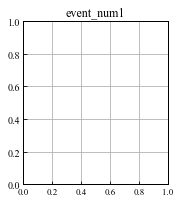

In [286]:
def make_time_series_graphs_of_five_events(column_name='Load_Avg'):
    
    fig = plt.figure(figsize=(15, 3))
    for i in range(1,len(df_event_num)+1):
        ax = plt.subplot(150+i)
#        x0 = pd.date_range(df_event_num[i-1].index[0],df_event_num[i-1].index[0])
        plt.title('event_num{}'.format(i))
        df_event_num[i-1][column_name].plot(color=event_color_2018[i-1])

#        ax.set_xticklabels(x0,rotation=90,size="small")
#        ax.tick_params(rotation=270)
        if column_name == 'Load_Avg':
            plt.ylabel('Pit weight[kg]')
        elif 'Load_Avg_difference' in column_name:
            plt.ylabel('Bedload discharge[kg min-1]')
        elif 'Tot' in column_name:
            num_of_amplification = amplification_factor[column_name]
            plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
        else:
            plt.ylabel('Worning!Imputted Unknown data.')
            
    fig.tight_layout()
    save_dir_seminers = './graphs_for_seminers/' 
    plt.savefig(os.path.join(save_dir_seminers, column_name + 'time_series_graph' + year + process))
%matplotlib inline
make_time_series_graphs_of_five_events('Load_Avg')
make_time_series_graphs_of_five_events('Load_Avg_difference')
make_time_series_graphs_of_five_events(y_name)

In [171]:
#イベント１～５まで結合
df_12345 = pd.concat([df_event_num[0], df_event_num[1], df_event_num[2], df_event_num[3], df_event_num[4]], sort=False)

In [172]:
#ピット内が０～２００kg,２００～４００kg,２００～４００kg.......１４００～１６００kgの時を取り出す
df_12345_cut = [0]*8
for i in range(len(df_12345_cut)):
    df_12345_cut[i] = cut_by_pit_value(i*200, (i+1)*200, df_12345)

In [173]:
def make_graphs_5events_Tot_from_1to10():

    if process == "sum_dia":
        range_max = 10
    else:
        range_max = 11
    num_of_amplification = None
    for i in range(1,range_max):
        y_name = "hp_Tot({})".format(i)
        x_name = "Load_Avg_difference"
        num_of_amplification = amplification_factor[y_name]
#         x_name = "C_Tot({})".format(i)

        save_dir = './scatter_gparhs_by_pit_fill_rate/' 

        fig = plt.figure(figsize=(10, 10))
        plt.title("correlation" + y_name + "_" + x_name)

        
        
        ylim = max(df_12345[y_name])
        xlim = max(df_12345[x_name])
        margin = ylim/20

        for i in range(len(df_12345_cut)):
            x = df_12345_cut[i][x_name]
            y = df_12345_cut[i][y_name]
            plt.subplot(331 + i)
            plt.title("{0}to{1}".format(i*200, (i+1)*200))
            plt.scatter(x, y, marker='.')
            plt.xlim(-1,xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg min-1]')
        plt.subplot(339)
        plt.title("200-1200")
        for i in range(1,6):
            x = df_12345_cut[i][x_name]
            y = df_12345_cut[i][y_name]
            plt.scatter(x, y, marker='.')
            plt.xlim(-1,xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg min-1]')


        fig.tight_layout()
        plt.savefig(os.path.join(save_dir, y_name +"2018_5events" + "_" + process))
#         plt.savefig(os.path.join(save_dir, "correlation" + y_name + "_" + x_name))

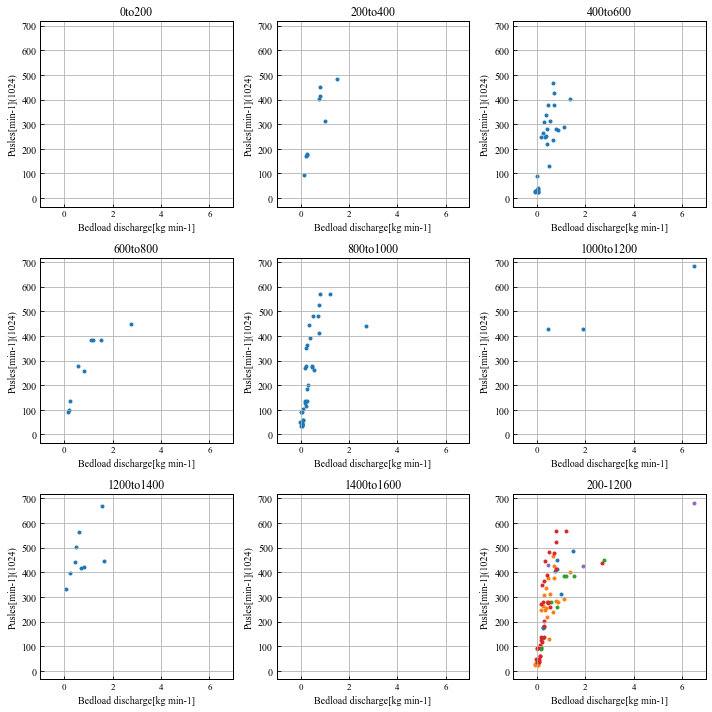

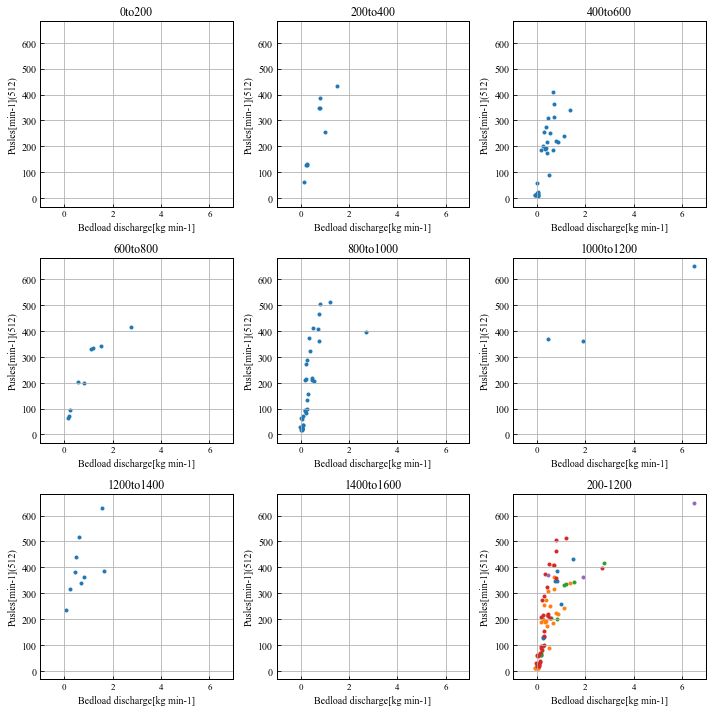

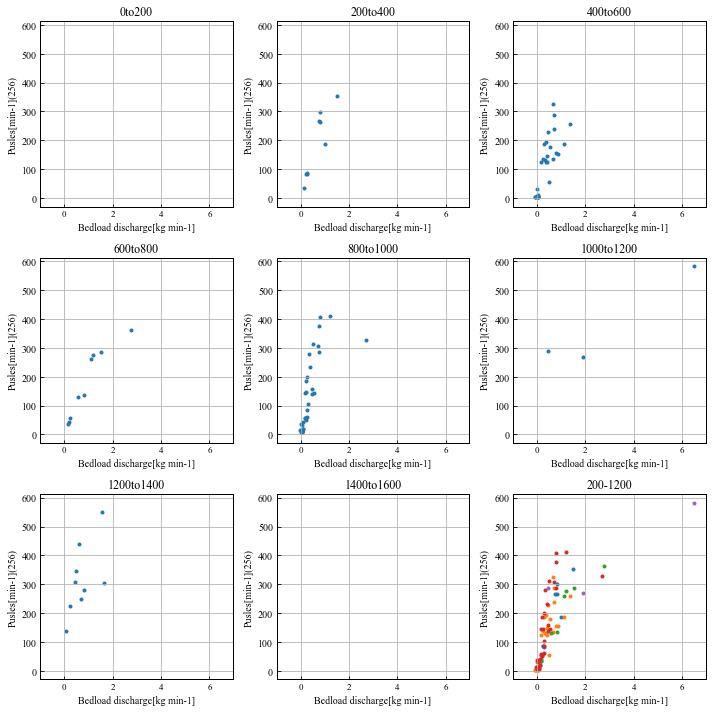

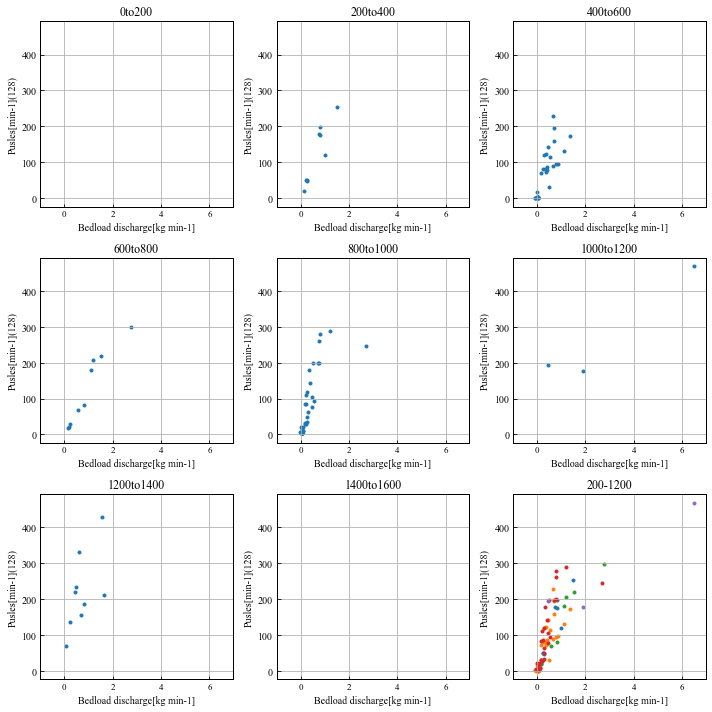

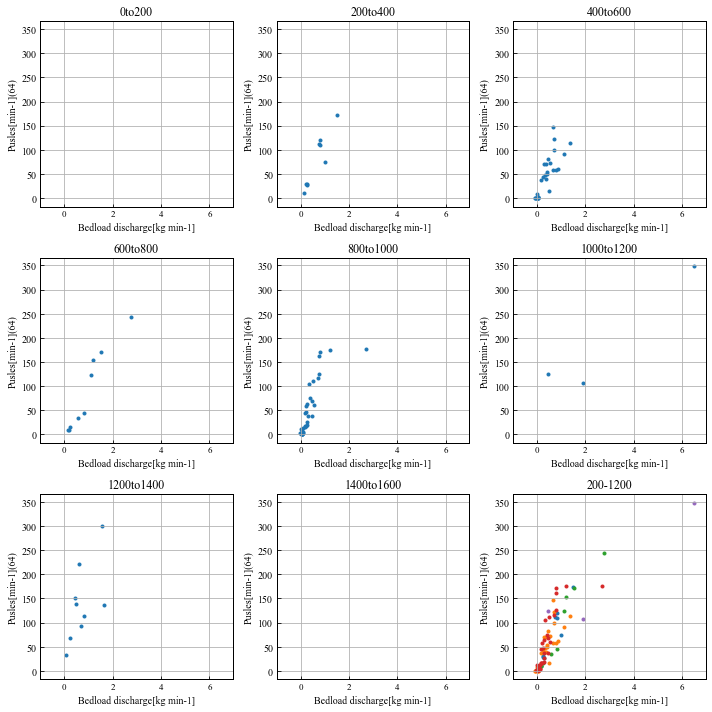

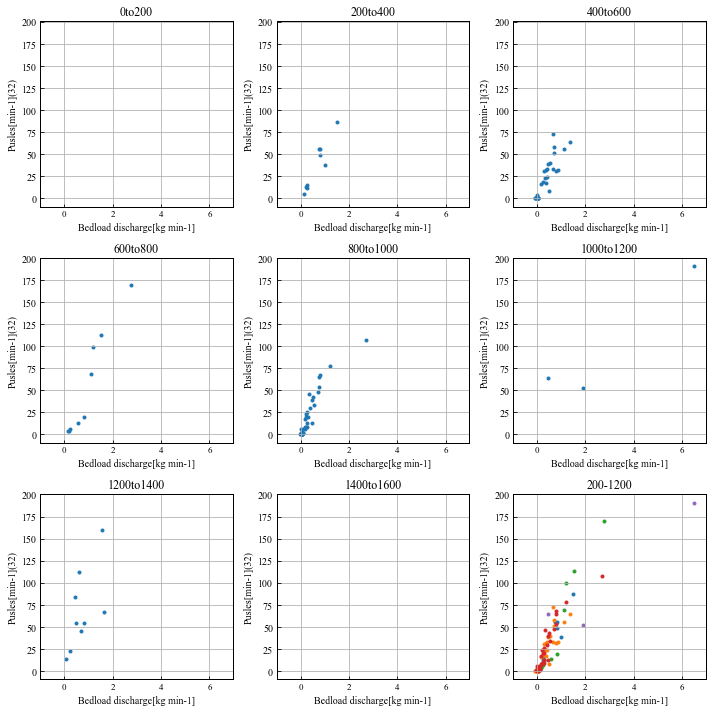

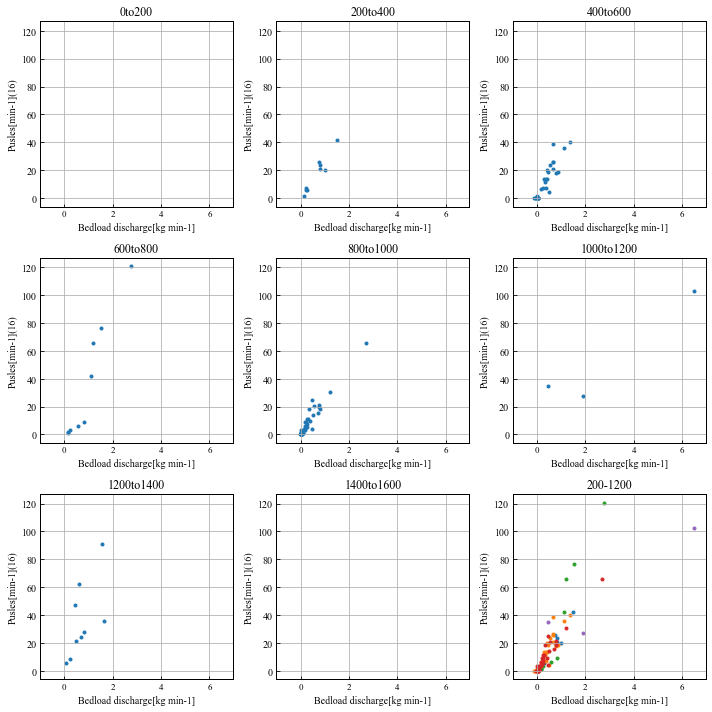

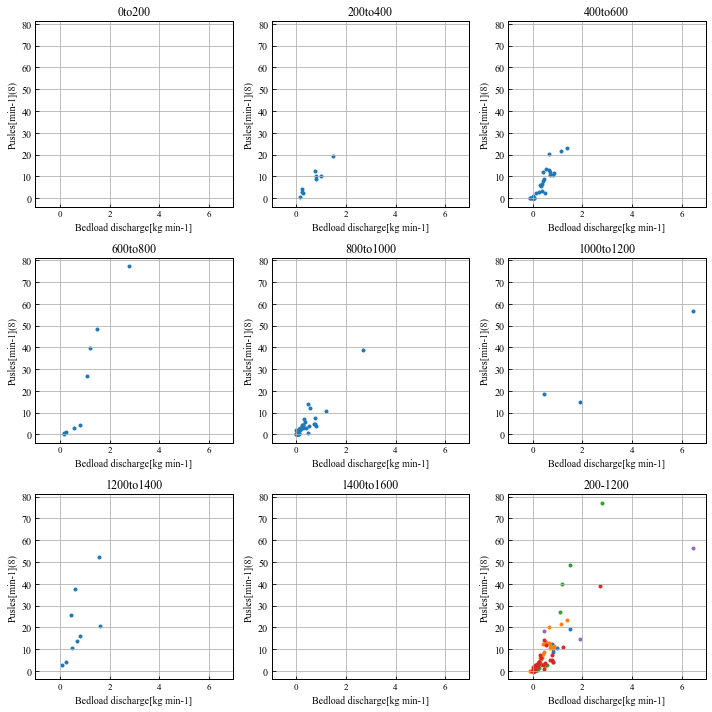

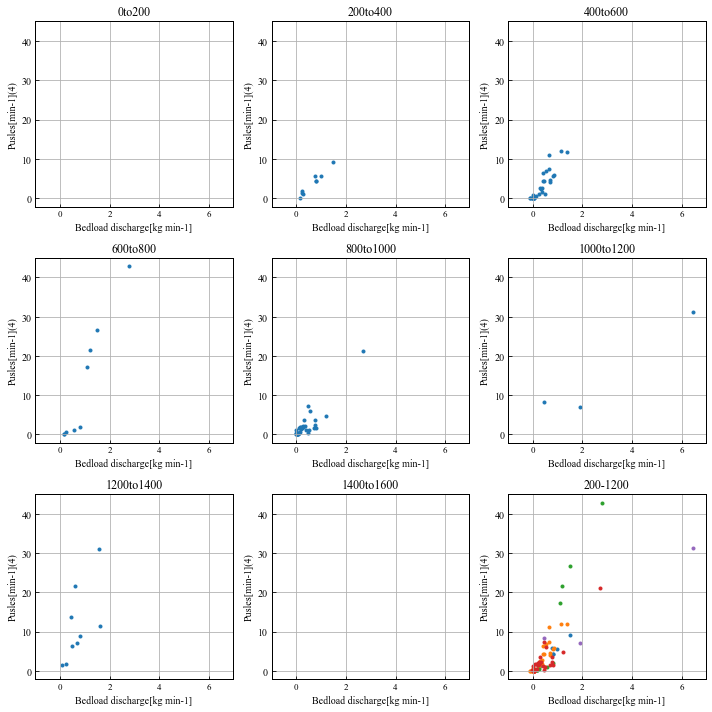

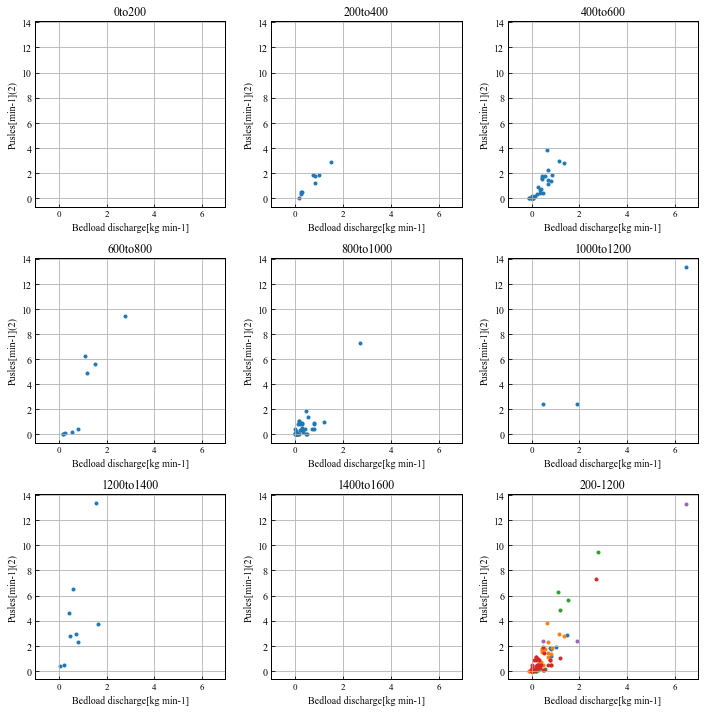

In [174]:
make_graphs_5events_Tot_from_1to10()

In [175]:
#使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"

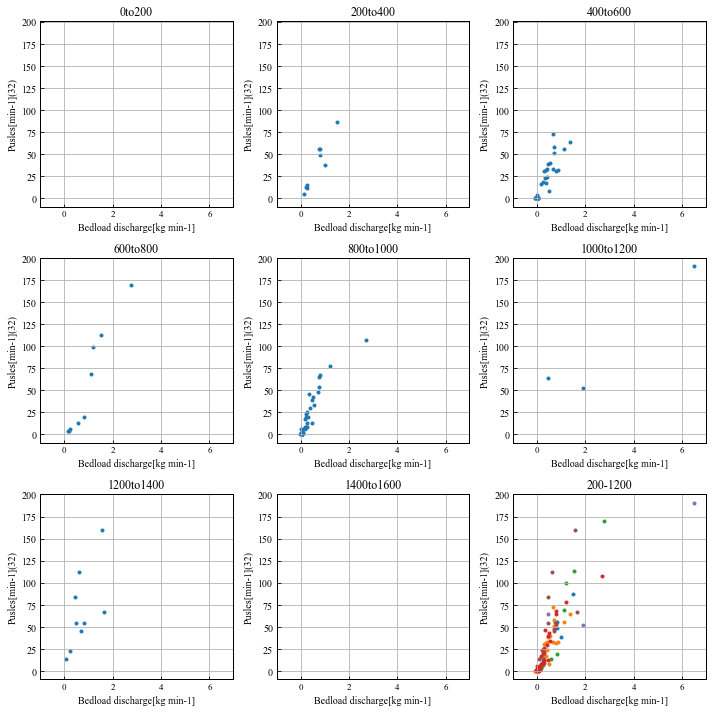

In [176]:
save_dir = './scatter_gparhs_by_pit_fill_rate/' 
num_of_amplification = amplification_factor[y_name]


%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ylim = max(df_12345[y_name])
xlim = max(df_12345[x_name])
margin = ylim/20

for i in range(len(df_12345_cut)):
    x = df_12345_cut[i][x_name]
    y = df_12345_cut[i][y_name]
    plt.subplot(331 + i)
    plt.title("{0}to{1}".format(i*200, (i+1)*200))
    plt.scatter(x, y, marker='.')
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')

plt.subplot(339)
plt.title("200-1200")
for i in range(1,7):
    x = df_12345_cut[i][x_name]
    y = df_12345_cut[i][y_name]
    plt.scatter(x, y, marker='.')
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')    
    
fig.tight_layout()
plt.savefig(os.path.join(save_dir, y_name +"2018_5events" + "_" + process))

In [177]:
for i in range(len(df_event_num)):
    df_event_num[i] = cut_by_pit_value(0, 1200, df_event_num[i])

In [178]:
#イベント１～５まで結合
df_12345 = pd.concat([df_event_num[0], df_event_num[1], df_event_num[2], df_event_num[3], df_event_num[4]], sort=False)

In [179]:
#使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(9)"

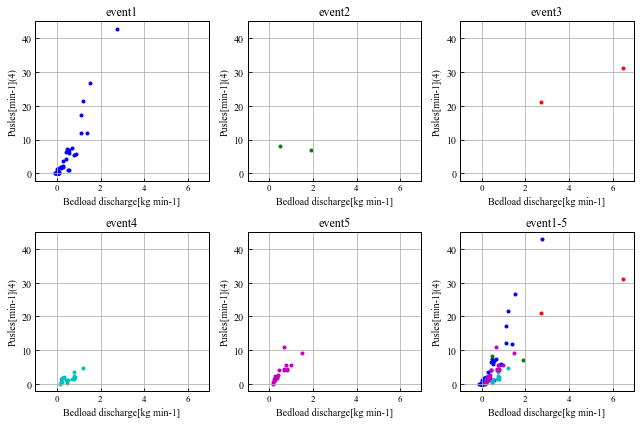

In [180]:
save_dir_seminers = './graphs_for_seminers/' 
num_of_amplification = amplification_factor[y_name]

%matplotlib inline
fig = plt.figure(figsize=(9, 6))
ylim = max(df_12345[y_name])
xlim = max(df_12345[x_name])
margin = ylim/20

for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.subplot(231 + i)
    plt.title("event{0}".format(i+1))
    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')

plt.subplot(236)
plt.title("event1-5")
for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg min-1]')

fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers, y_name +"2018_5events" + "_" + process))

## 相関関数を決め、流砂量予測。さらに、実測値と比較

In [39]:
#重み付き最小二乗法（単純な最小2乗法ではない）
def linear_regression(df_X, df_Y, color='r'):

    """
    X:input of x ax(example:x_cols)
    Y:input of y ax(example:x_cols)
    """
    #fit_intercept	False に設定すると切片を求める計算を含めない。
    #目的変数が原点を必ず通る性質のデータを扱うときに利用。 (デフォルト値: True)
    clf = linear_model.LinearRegression(fit_intercept=False)
    
    X = df_X.values.reshape(-1, 1)
    Y = df_Y.values.reshape(-1, 1)
    clf.fit(X,Y)
    y_hat = clf.predict(X)
    
    # 近似直線との誤差を計算する
    diff = Y - y_hat
    
    # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
    sample_weight = (np.max(np.abs(diff)) - np.abs(diff)).astype('float32').T[0] ** 2
    
    # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
    #詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
    clf.fit(X, Y, sample_weight=sample_weight)
#     y_hat    = clf.predict(X)
    
#     # 近似直線との誤差を計算する（再）
#     diff     = y - y_hat
    
    
#     #傾きをレジェンド表記
#     print(clf.intercept_)
##　レジェンドに切片を含める
#     label_slope= "slope:" + str(round(clf.coef_.flatten()[0],1)) + \
#                             "\n" + "intercept:" + str(round(clf.intercept_,1)) + \
#                             "\n" + "R^2:" + str(round(clf.score(X, Y).flatten()[0],1))
##　レジェンドに切片を含めない（切片０だから）    
#     print("R^2=",clf.score(X, Y))
    label_slope= "slope:" + str(round(clf.coef_.flatten()[0],2)) + \
                            "\n" + "R^2:" + str(round(clf.score(X, Y),2))
    
#     print("切片：",clf.intercept_)
#     plt.scatter(X, Y)
    # 回帰直線
    plt.plot(X, clf.predict(X), label=label_slope, c=color)
    plt.legend()
    
    return clf.coef_.flatten()[0]

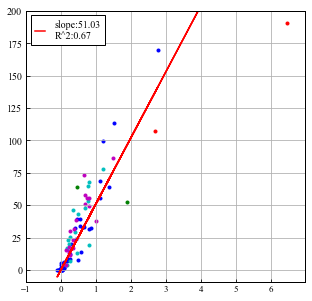

In [40]:
save_dir_seminers = './graphs_for_seminers/' 
%matplotlib inline
plt.figure(figsize=(5,5))
slope = linear_regression(df_12345[x_name], df_12345[y_name])
ylim = max(df_12345[y_name])
xlim = max(df_12345[x_name])
margin = ylim/20
for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(-1,xlim+0.5)
    plt.ylim(-margin, ylim + margin)

plt.savefig(os.path.join(save_dir_seminers, "linear_regression" + y_name + process))


In [41]:
print("Y = " + str(round(slope,3)) + "X")

Y = 51.026X


In [42]:
for i in range(len(df_event_num)):
    df_event_num[i]["sediment discharge_calc"] = df_event_num[i][y_name] / slope

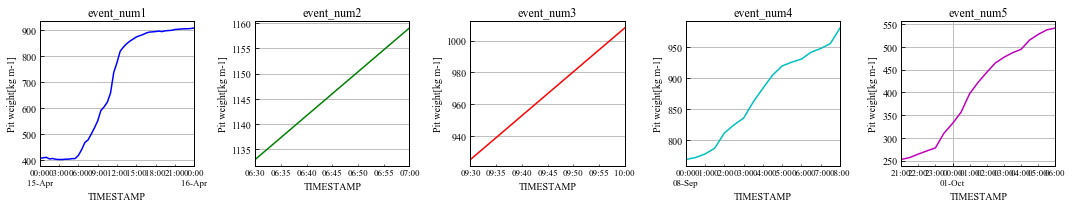

In [43]:
make_time_series_graphs_of_five_events('Load_Avg')

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


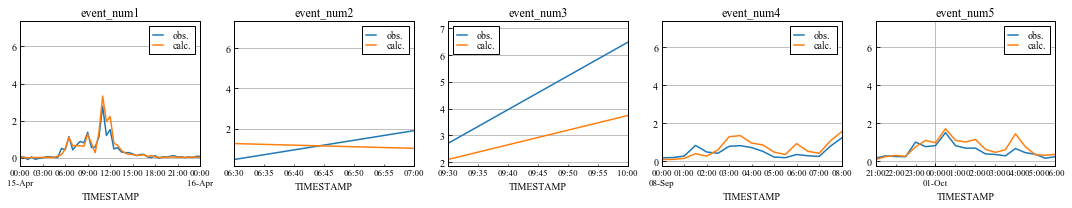

In [44]:
fig = plt.figure(figsize=(15, 3))
for i in range(len(df_event_num)):
    df_event_num[i]["sediment_discharge_calc"] = df_event_num[i][y_name] / slope
    
    ax = plt.subplot(151+i)
    plt.title('event_num{}'.format(i+1))
    df_event_num[i]['Load_Avg_difference'].plot(label='obs.')
    df_event_num[i]['sediment_discharge_calc'].plot(label='calc.')
    ax.plot(0,7)
    plt.legend()

fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers, 'comparison_of_Load_Avg_difference_btw_obs_and_calc'))
fig.show()

504.40000000000043   561.7341934497448   1.113668107553022
71.0   68.45541421763102   0.9641607636286059
275.00000000000006   175.20509679519648   0.6371094428916234
245.99999999999997   331.2434615248781   1.3465181362799925
298.4   402.2661987492397   1.3480770735564336


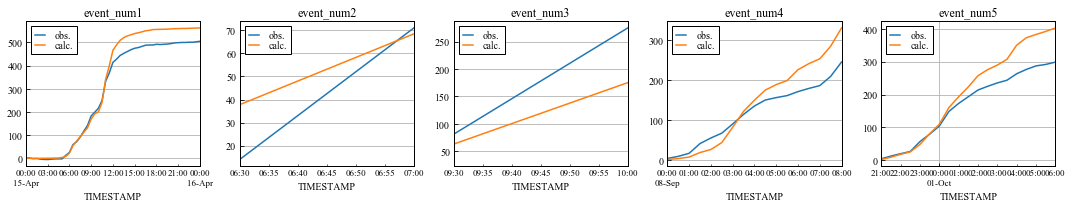

In [45]:
fig = plt.figure(figsize=(15, 3))
for i in range(len(df_event_num)):
    df_event_num[i]["sediment_discharge_cumsum_calc"] = df_event_num[i]["sediment_discharge_calc"].cumsum()*sum_interval
    df_event_num[i]["sediment_discharge_cumsum_obs"] = df_event_num[i]["Load_Avg_difference"].cumsum()*sum_interval

    ax = plt.subplot(151+i)
    plt.title('event_num{}'.format(i+1))
    df_event_num[i]["sediment_discharge_cumsum_obs"].plot(label='obs.')
    df_event_num[i]['sediment_discharge_cumsum_calc'].plot(label='calc.')
    ax.plot(0,35)
    plt.legend()
    print(df_event_num[i]["sediment_discharge_cumsum_obs"][-1],' ' ,df_event_num[i]["sediment_discharge_cumsum_calc"][-1], ' ',\
         df_event_num[i]["sediment_discharge_cumsum_calc"][-1]/df_event_num[i]["sediment_discharge_cumsum_obs"][-1])

fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers, 'comparison_of_Load_Avg_btw_obs_and_calc'))

## ピット直上ハイドロフォンと５つのハイドロフォンのセンターハイドロフォンとの比較

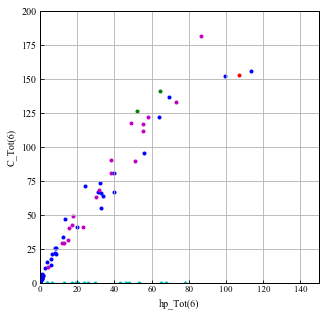

In [46]:
plt.figure(figsize=(5,5))
for i in range(len(df_event_num)):
    x = df_event_num[i]["hp_Tot(6)"]
    y = df_event_num[i]["C_Tot(6)"]
    
    plt.scatter(x, y, marker='.', color = event_color_2018[i])
    plt.xlim(0, 150)
    plt.ylim(0, 200)
    plt.xlabel("hp_Tot(6)")
    plt.ylabel("C_Tot(6)")

In [47]:
#イベント３のデータが死んでいるので、イベント１、２，４，５を結合
df_1235 = pd.concat([df_event_num[0], df_event_num[1], df_event_num[2],  df_event_num[4]], sort=False)

Text(0, 0.5, 'C_Tot(6)')

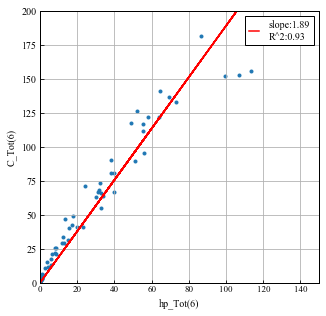

In [48]:
plt.figure(figsize=(5,5))
slope_hp_C = linear_regression(df_1235["hp_Tot(6)"], df_1235["C_Tot(6)"])
x = df_1235["hp_Tot(6)"]
y = df_1235["C_Tot(6)"]
plt.scatter(x, y, marker='.')
plt.xlim(0, 150)
plt.ylim(0, 200)
plt.xlabel("hp_Tot(6)")
plt.ylabel("C_Tot(6)")

In [49]:
print("Y = " + str(round(slope_hp_C,3)) + "X")

print("長さの比は、" + str(50/27.5))

Y = 1.89X
長さの比は、1.8181818181818181


Text(0, 0.5, 'C_Tot(6)')

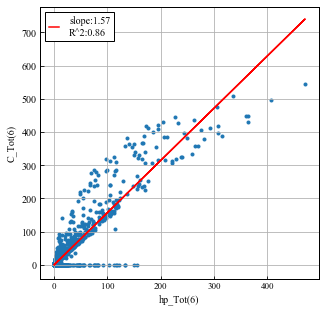

In [50]:
#全ての"hp_Tot(6)"と"C_Tot(6)"データとの比較
plt.figure(figsize=(5,5))
slope_hp_C_all = linear_regression(df_fin["hp_Tot(6)"], df_fin["C_Tot(6)"])
plt.scatter(df_fin["hp_Tot(6)"], df_fin["C_Tot(6)"], marker='.')
plt.xlabel("hp_Tot(6)")
plt.ylabel("C_Tot(6)")

In [51]:
print("Y = " + str(round(slope_hp_C_all,3)) + "X")

Y = 1.572X


## センターハイドロフォンとピットの流砂量との相関から、横断分布を計算し、動画として保存

<IPython.core.display.Javascript object>


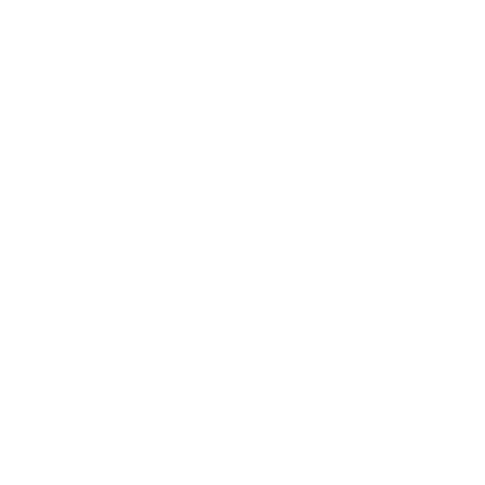

MovieWriter imagemagick unavailable. Trying to use pillow instead.


<IPython.core.display.Javascript object>


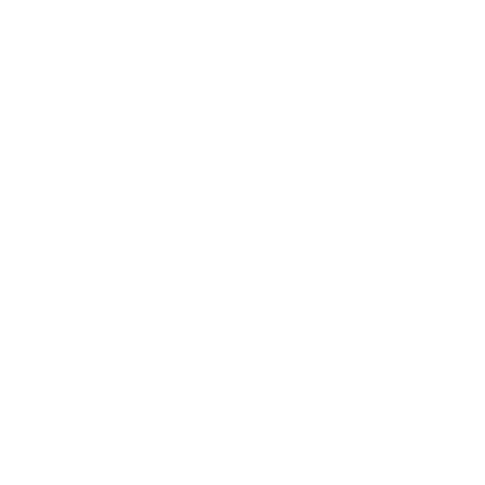

Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [52]:
save_dir_seminers = './graphs_for_seminers/' 
#イベント番号を入力（１～５まで）
event_num=5
#スロットナンバーを入力（１～９まで）
slot_num=6
#イベント番号とスロットナンバーを入力したらCrtlプラスEnterでグラフ表示

place_of_hydrophones = ['L_Tot({})'.format(slot_num),'LC_Tot({})'.format(slot_num),'C_Tot({})'.format(slot_num),'RC_Tot({})'.format(slot_num),'R_Tot({})'.format(slot_num)]
df = df_event_num[event_num-1][place_of_hydrophones] / slope_hp_C /slope
    
%matplotlib nbagg

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

x = np.array(['R', 'RC', 'C', 'LC', 'L'])
max_ylim = max(df.max())
def update(i, fig_title, A):
    if i != 0:
        # 現在描写されているグラフを消去
        plt.cla()

    y = [df[place_of_hydrophones[4]][i], df[place_of_hydrophones[3]][i], df[place_of_hydrophones[2]][i],df[place_of_hydrophones[1]][i], df[place_of_hydrophones[0]][i]]
    plt.bar(x, y)
    plt.grid()
    
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("Load_Avg_Difference", fontsize = 15)
    
    plt.ylim(0,max_ylim)

    plt.title(fig_title + ":" + str(df.index[i]))


ani = animation.FuncAnimation(fig, update, fargs = ('TIMESTAMP ', 2.0), \
    interval = 200, frames = len(df.index), repeat = False)

ani.save(os.path.join(save_dir_seminers, 'animation_event'+ str(event_num) +'.gif'), writer = 'imagemagick')

<BarContainer object of 5 artists>

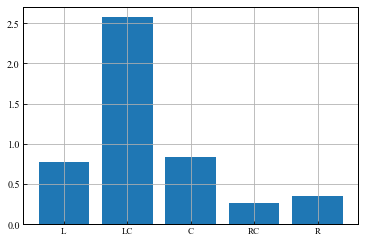

In [53]:
%matplotlib inline
i=4
x = np.array(['L', 'LC', 'C', 'RC', 'R'])
y =np.array([df[place_of_hydrophones[0]][i], df[place_of_hydrophones[1]][i], df[place_of_hydrophones[2]][i],df[place_of_hydrophones[3]][i], df[place_of_hydrophones[4]][i]])
plt.bar(x, y)

## 粒径ごとのデータに重さをかけて、ソルバー

In [54]:
data_type = 'hp_Tot'

# data_typeのデータのcolumn名を取り出す
names_of_data_type = []
names_of_data_type = [i for i in df_dia_all_2018.columns if data_type in i]

In [55]:
from scipy.optimize import minimize

In [56]:
# 目的関数
def func(W):
    Cost = 0
    W = W.reshape(1,9)
    print('W', W.shape)
    for i in range(5):
#         if i == 2:
#             pass
#         elif i == 3:
#             pass
#         else:
            Y = df_event_num[i]['Load_Avg_difference'].values.reshape(len(df_event_num[i]['Load_Avg_difference']),1)
#             print('Y' , Y.shape)
            X = df_event_num[i][names_of_data_type]
#             print('X', X.shape)
            Z = np.dot(X, W.T)
#             print('Z', Z.shape)
            A0 = np.abs(Z-Y)
#             print('A0' , A0.shape)
            A1 = np.power(A0,2)
#             print('A1' , A1.shape)
            cost = np.sum(A1 ,axis=0, keepdims=True)
#             print('cost' , cost.shape)
            Cost = Cost + cost[0][0]
        print('Cost' , Cost)
    return Cost

cons = ({'type': 'ineq', 'fun': lambda W: W[1]-W[0]},
        {'type': 'ineq', 'fun': lambda W: W[2]-W[1]},
        {'type': 'ineq', 'fun': lambda W: W[3]-W[2]},
        {'type': 'ineq', 'fun': lambda W: W[4]-W[3]},
        {'type': 'ineq', 'fun': lambda W: W[5]-W[4]},
        {'type': 'ineq', 'fun': lambda W: W[6]-W[5]},
        {'type': 'ineq', 'fun': lambda W: W[7]-W[6]},
        {'type': 'ineq', 'fun': lambda W: W[8]-W[7]},
        {'type': 'ineq', 'fun': lambda W: W[0]}
       )

times_of_try = 100
minmum_cost = 100
temp = []
W_ans = []
results = []
for i in range(times_of_try):
    W0 = np.random.rand(1,9)# 初期値は適当
    result = minimize(func, x0=W0, constraints=cons, method="SLSQP")
    if result.fun < minmum_cost:
        minmum_cost = result.fun
        W_ans.append([i, result.x])
        temp.append([i, minmum_cost])
        results.append([i, result])
    

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8756230.349457532
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10465688.66239972
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15729323.831055235
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 26521406.058322206
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 35817999.173034206
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8756230.349457532
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10465688.66239972
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15729323.831055235
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 26521406.058322206
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 35817999.173034206
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8756230.464400452
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17717421.17047976
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 30326169.389041394
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 41290270.83640558
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10290968.382534422
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12282601.477028431
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17717421.159773745
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 30326169.374186255
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 41290270.81697087
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10290968.37812439
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12282601.472082417
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17717421.152687218
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 362924.827920788
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 614517.8458359418
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 714726.4902049403
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 839805.7520981826
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 337386.97248975554
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 362924.8495134865
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 614517.8795139602
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 714726.5375414004
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 839805.8136827832
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 337386.9700038172
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 362924.8466170662
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6145

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 57.05845259263483
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 58.316000838292304
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 60.537869501810796
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 53.651186871498474
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 55.11762510726989
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 57.058413247630874
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 58.315970181844655
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 60.53783176679318
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 53.651158488891284
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 55.1175958490425
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 57.05838435484917
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25.227784415481725
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.489932849832447
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.6340231688341884
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.534748710860022
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 23.50262703003859
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25.227771732746408
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.489933636116939
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.6340246107706315
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.53476085500082
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 23.502624425770133
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25.227759778339657
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.267657600226086
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.458130995159017
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.5068449575673224
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.8519402316071436
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.171375369244751
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.267659119874981
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.458127070340021
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.50684000594457
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.8519353884958396
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.171385026113663
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.267663635110551
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (1

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294282623055588
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453541154119984
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6258680256475357
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9703178128764094
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259918105958118
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294279564886002
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453531945895115
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6258623985447795
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.970312570408809
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259923878572724
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294278573870777
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (1

A1 (49, 1)
cost (1, 1)
Cost 380437762679821.5
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 460632704963173.4
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 652379836505932.5
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1184080804182487.8
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1631882479542829.5
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3796486395318.9487
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4596843136823.584
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6509859099441.73
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11816639113795.13
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 16285921592189.082
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 37180322287.679825
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 45025492618.091576

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3604327.0265553705
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5621631.38442934
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7403340.221882686
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1929355.2645664145
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2265707.8245738223
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3604327.034657769
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5621631.4469772
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7403340.327340509
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1929355.2660758104
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2265707.826804095
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3604327.0354680084
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost 

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5618117.370414282
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7397225.79974734
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1929280.7812924453
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2265590.202083218
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3604310.927432061
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5621279.706761425
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7402728.4234297
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1929280.7812924453
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2265590.202083218
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3604310.927432061
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5621279.706761425
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3103918.5719050183
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4896785.981224237
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 6506384.552417368
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19503999.893662475
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 19593690.08187848
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 21113451.554884978
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 24538855.498219907
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25492334.12957233
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2593192.5494806315
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2870273.4748366373
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3956955.4439850543
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1503336.66842252
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2284163.0896657743
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3312434.052316984
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4307657.349036114
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1307634.7807875928
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1503336.6615138755
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2284163.079109039
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3312434.0334428707
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4307657.323284224
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1307634.7753657904
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1503336.6550120278
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2669.94637551302
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2788.2536894985246
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3618.1549038614544
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3742.7025227347244
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4170.8621849066
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.7042888140639922
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.107542946008724
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.574932278008294
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14.183133406701202
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.088516035179167
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.7042888140639922
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
C

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.2608702917016523
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.656616746352054
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.186505877115867
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.865893293016356
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.818737452157563
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.2608666426297943
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.656613142138323
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.186510474090513
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.865896749471665
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.818739193162006
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.2608636851620068
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7630870753571006
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.207677976493857
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.293721446968792
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.462637969992532
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.4179206698966604
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7630840792790687
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.207683188904916
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.293724300134011
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.462638654442145
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.41791825677683
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7630816361558566
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cos

A1 (17, 1)
cost (1, 1)
Cost 13.29466461546236
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520807399336
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.62562412403527
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9700745121474865
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.260124524610934
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294384923855558
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520686743664
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6255498038743434
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9699992154280377
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.26042880047648
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29452603598012
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45352071

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17011178.887017917
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4502070.325118386
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5325144.22104359
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7666130.523724418
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 12592335.558034884
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17011178.880300038
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8512559.229318323
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10123623.375871385
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15038660.325246356
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25039478.084832937
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 33788088.40059798
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)


Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7976159.688706852
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9518890.291014671
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14355731.043165011
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 23975561.71717766
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 32315556.685213197
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7976159.6832078975
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9518890.284743935
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14355731.033388712
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 23975561.703758053
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 32315556.66777498
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7976159.679227871
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4008439.5021443423
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4703604.048688562
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7095829.76712987
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11190681.612424862
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14893865.444598995
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4008439.4920862135
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4703604.036197995
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7095829.748253632
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11190681.576940835
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14893865.395822626
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4008439.4825576413
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
co

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9473553.469312262
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11324423.758884026
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16172425.07595341
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27913779.54001123
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 38116813.37607948
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9473553.46127184
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11324423.74929875
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16172425.060016371
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27913779.51329176
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 38116813.34026618
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9473553.45543315
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1,

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1.863981334040691e+17
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 434396500913483.1
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 525981388610335.4
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 744750549663213.9
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1352052795863419.8
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1863500552371696.8
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4332396278060.302
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5245908687377.794
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7427341759363.311
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13485345136150.848
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18586961654869.89
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 482676.1165043482
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 696815.4665379336
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1100886.6269332403
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1473755.3461241429
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 412600.38283900724
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 482676.11549458676
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 696815.465102961
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1100886.6253005913
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1473755.3441079166
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6503167054544278e+17
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.2089359057702106e+17
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 240552.7153798707
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 349194.4597460906
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 520602.9831069495
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 686514.6407493905
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10810.300626823968
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10924.511393641376
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17295.8641820288
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21965.728467444133
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25098.309504098415
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10810.300626823968
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10924.511393641376
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25098.312050548153
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10810.302017016555
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10924.512660124074
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17295.868090026386
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21965.730482256287
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25098.31041198602
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10810.302250727174
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10924.512913922821
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17295.868235521528
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21965.73108075981
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25098.31132323635
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49,

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23.706689234110033
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.92778030922342
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.36785329719616
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.76717822817808
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.86169033914395
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23.706702757948637
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.92781415580379
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.36789414070083
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.76722663166805
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.86169918868677
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23.706712563957744
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6301127947752354
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.105893016178916
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9.602531893705802
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.93142828744335
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 20.543817343419953
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.258641503069436
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.6050328265036757
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.565236722982853
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.491162976853834
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.511137632507563
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.258641503069436
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294241112371797
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520004792802
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6251890021125863
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9696418968124205
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.25972306075208
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294241112371797
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520004792802
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6252226414625666
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9696736980806224
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259689801914641
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294237948863138
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cos

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13049503.996288665
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17577179.963612597
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4581259.373664239
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5419569.115207421
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7967654.07392881
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13049503.957667
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17577179.910284106
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4581259.363488197
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5419569.10279618
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7967654.053372901
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13049503.921441972
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
C

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.15788402708
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 213976.1696828917
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232461.5242177629
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113285.85491747859
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116561.43519617876
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.15512933748
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 213976.166493734
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232461.5202674953
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113285.85384610365
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116561.43396538854
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.1526984012
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.14864888164
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 213976.15894301728
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232461.5112180649
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113285.85146981185
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116561.43135275326
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.14752123333
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 213976.15773687328
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232461.50986036277
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113285.85099472507
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116561.43085608532
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201346.1467594344
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)


Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113397.74199884401
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116668.718993587
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201556.98462692506
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 214199.714256552
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232687.1259938862
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113298.85699679921
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 116573.02518485198
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 201369.885006537
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 214000.57397585403
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 232483.8425523891
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 113282.19957771545
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cos

A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 49094.85364385959
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 51335.38888087962
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 136572.21478682454
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 198101.17494809447
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 39069.50649538543
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 49094.862481397555
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 51335.398782203534
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 136572.23833274946
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 198101.2091499813
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 39069.50499765483
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 49094.86072166127
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 51335.39

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1268.1430857348846
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1322.2858368528146
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1667.620471246537
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1721.5393549715582
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1918.016076186776
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1268.1429277256611
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1322.2856613516622
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1667.6202030051425
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1721.5390380086135
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1918.0156783727361
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1268.1428342703955
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.37754991230274
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19.625889162542006
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 20.4652539364144
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8.59465699813111
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9.942692773631144
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.377548906538223
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19.62588916745338
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 20.46525412823949
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8.594652982834702
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9.942688825780547
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.377547306949637
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cos

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.935130223321273
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.2943112432181048
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.318603422444426
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14.033418429966217
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.838400179164074
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.3007941001371517
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.646440011989255
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.166757817545733
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294790650910402
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.477371032334398
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.3007941001371517
Y (2, 1)
X (2, 9)
Z (2, 1)


X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9663680342834624
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.258675816743695
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294041291357079
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453523972594338
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.621901839016335
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.966366091488395
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.258676314066424
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294041592032169
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453523777641987
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.625608343857802
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.970058746005126
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost 

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8343327.255353805
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 11181550.52176851
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3991557.5880438974
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4729623.160174119
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6751266.130424947
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11262722.59460577
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15286653.340279035
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3991557.5880438974
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4729623.160174119
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6751266.130424947
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11262722.59460577
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10423779.30241788
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12465679.648908958
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17646962.456162803
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 30484129.684569262
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 41662357.33347542
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10423779.296303092
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12465679.64190755
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17646962.44553333
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 30484129.66976197
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 41662357.31405294
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10423779.291897234
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 131579.57704397672
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 143439.44782754823
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 79882.42369681237
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 82823.95974310931
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 127056.95706137078
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 131579.5932325588
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 143439.46783162106
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 79882.42276293675
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 82823.95867276035
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 127056.95568161496
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 131579.59163762518
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.86450570622807
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 18.675415489003562
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22.54695314273683
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.15752330005915
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.21748937305361
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.8646172528984
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 18.675435734536435
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22.546978320377235
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.15757732943769
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.21756244868587
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.86470824396076
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
co

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25.323888082417266
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 31.408779251811094
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 15.548417440804858
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17.239937656939922
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.595342241975896
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25.32409834464497
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 31.40908948555054
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 15.548397319876413
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17.239916002170965
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.59532204184795
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25.324063523013965
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19,

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.81743837764939
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.882354230712034
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.15872083314974
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.451379472731471
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.6458775972503825
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.817440787440153
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.882355821216027
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.15872139474607
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.4513775701910836
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.645875666469334
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.817441686212895
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
c

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.309197843621089
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.31364165557357
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.454415026029634
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.66500801938911
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.009201805602201
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.309197843621089
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.31364165557357
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.454415026029634
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6650420042094765
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.009233881223947
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.309164843022282
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29438206590508
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453540629351465
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.625633628399688
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.970083267034917
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.260100368320533
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294379009187995
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45353142313063
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.625628001901186
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.97007802528932
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.260106141973361
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294378019824233
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6403390.783928132
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9952008.20000479
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 13175165.93835139
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3565937.9291420514
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4177235.2383158086
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6403390.783928132
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9952008.20000479
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 13175165.93835139
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3565938.0010662694
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4177235.3243234083
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6403390.905987166
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost 

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22111093852687.516
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 31294324765705.51
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 56839603645745.3
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 78350255474881.25
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 180132031601.08862
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 218135031866.17853
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 308705091482.48236
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 560827602377.0461
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 773108507380.7222
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1563914273.195101
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1894861973.3038158
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7898375.656163634
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14202427.822360277
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16791749.01408508
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18711205.597596057
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 380973.4429255651
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 460229.26045549917
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 566396.2412694047
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1111599.3779794292
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1570616.7822287544
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 569167.4930921089
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 664110.7848323247
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1009583.4242662956
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1543816.8579025352
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2029111.5730020904
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 557821.3479572278
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 650593.6768805727
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1009583.4181319941
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1543816.8467935813
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2029111.5572109553
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 557821.3426603376
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 650593.6704749912
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1009583.4100738922
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 418124.9209987409
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 104128.82882891815
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 124894.58447052314
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 168297.2274034617
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 302594.0495217602
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 418124.9200008551
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4028942.935297666
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4171103.4476642893
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5982061.495751105
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9015798.196086925
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 11180777.310430259
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4884469.743650271
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 6630073.2607788835
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1622565.985357139
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1942787.2325730482
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2853771.3170925165
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4884469.715814901
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 6630073.221340904
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1622565.9759428627
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1942787.2209237975
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2853771.3014554707
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4884469.685343901
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 400862.91676992696
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 433550.05215399
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 724035.0448606468
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 849886.5173397751
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1005270.078035013
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 400862.91676992696
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 433550.05215399
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 724035.0448606468
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 849886.5173397751
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1005270.078035013
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 400862.93734015984
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 43

cost (1, 1)
Cost 1001450.6669094441
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 399700.34309206094
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 432215.1907705588
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 721895.1343154664
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 846917.9042158086
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1001450.6561694342
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 399700.34142959624
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 432215.1889032322
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 721895.130889505
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 846917.8996615667
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1001450.6504934125
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 399700.34014273

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10127.45363894102
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4110.60867397326
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4122.8614151023885
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7560.837334603357
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9066.146926330497
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10127.453748932714
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4110.608554680724
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4122.86129092642
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7560.837289816411
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9066.146643421736
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10127.453306027192
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cos

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.71428367941129
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23.541696338502003
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.64812154546931
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.10640953295
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.50778595672021
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.714304081117998
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23.54172070749999
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 72.64818190127022
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 78.10648523017555
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 85.50787702918986
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.714315748779537
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1,

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.686296941926573
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.528540182445262
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.859113657955389
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.503299213664782
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.3873455598304405
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.6862930624456745
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.528540178732108
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.859112592365262
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.503296755071052
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.387342762450772
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.686290193606808
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6369921725356185
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.981445545537073
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.252993966932554
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.290333683122855
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453566821533109
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6369902426434666
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9814435933729273
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.252994451337905
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.290333970391782
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45356661161986
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6256134154871082
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7781006.862172359
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11447846.655233609
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19804386.32600781
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 26949304.17806518
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6472994.4759720685
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7781006.862172359
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11447846.655233609
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19804386.32600781
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 26949304.17806518
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6472994.575413613
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7781006.9822272565
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6598099.42888961
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 8758106.224205526
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2224906.68332911
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2628595.867910797
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4135668.899402689
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6598099.402981955
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 8758106.189602265
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2224906.679330976
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2628595.863190327
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4135668.8911308465
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6598099.389701681
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Co

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1.479937111872664e+19
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2.0397434824963224e+19
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.754963662600328e+16
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.757400645699753e+16
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8.15213421194124e+16
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1.4799070909945754e+17
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2.0397025305785018e+17
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 475396224098773.3
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 575620009692347.4
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 815039979651210.5
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1479606899087534.0
Y (19, 1)
X (19, 9)
Z (1

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 202632.07528984646
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 213645.82200466498
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 350655.19018158666
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 381442.32499277435
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 430626.0681974188
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 202310.61654720246
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 213331.19049036928
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 350021.1362575112
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 380833.65482306795
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 430034.5149096707
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 202278.50233225684
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1

cost (1, 1)
Cost 327933.9875575604
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 144289.79550400272
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 156750.58168403988
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 229837.33676975808
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 271499.78253016673
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 327933.9857062262
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 144289.79493385638
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 156750.58107127534
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 229837.33590863616
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 271499.7816048302
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 327933.9846288585
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2200.1444944

A1 (17, 1)
cost (1, 1)
Cost 8535.26743220636
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9122.755445776911
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6360.631577422282
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6531.444249267167
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8456.669475739314
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8541.37231282522
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9128.881108535254
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6362.018276842844
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6532.8443126436605
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8458.191498554615
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8542.838786887198
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9130.352596830762


Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8379.195395155228
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8458.021713692742
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9032.293576068669
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6321.683087795214
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6489.426395377497
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8379.195156971487
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8458.02146574091
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9032.293295779868
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6321.6829680782785
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6489.426270711907
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8379.194992290064
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1923.3487269221791
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1421.8702901243892
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1455.3532439529909
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1794.6268337683623
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1806.8215367636076
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1923.3485323788032
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1421.8702138323163
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1455.3531640878398
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1794.6267248279062
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1806.8214242011943
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1923.3484054430198
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16.387138464872052
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.09939225392033
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.222353220657538
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.557024529986615
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15.750658569812991
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16.38714447877365
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.099398203432937
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.222349729219275
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.5570211477638995
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15.750659965566552
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16.38714629671066
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259124516264063
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29405572196546
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520183866837
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.624182570990274
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9686400274673828
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259129436398783
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294058392581325
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45352071163288
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6241799976784264
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9686374230358887
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259131181471549
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5712577.1326701585
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1647551.2281930228
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1899721.7330371102
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3033410.7954221494
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4414960.547144171
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5712577.125079278
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1647551.2262999744
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1899721.7309526566
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3033410.792362462
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 4414960.543719771
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5712577.12093039
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)


X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1647656.2042835674
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2515461.311216728
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3901687.9162299614
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5163707.568539184
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1407440.2195461062
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1647656.2023856367
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2515461.308464395
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3901687.9131118236
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5163707.564710882
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 42929.42187502729
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 43218.80224190868
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1

cost (1, 1)
Cost 1178978.944325133
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1386362.5750436615
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2136303.8255462274
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3356836.3749750936
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4449866.479581184
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1178978.9365079876
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1386362.5655683659
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2136303.8136808556
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3356836.3528096545
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4449866.448347621
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1178978.9287677854
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1386362.5560306134
Y (2, 

cost (1, 1)
Cost 4449866.343258338
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1178978.9111315205
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1386362.5349559805
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2136303.7666946817
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3356836.272470621
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4449866.33972126
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2533076.1362045775
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2991930.0933491806
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4449735.549651832
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 7175815.624971377
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9616297.330880348
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2533076.1362045

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7983908.759054183
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11582924.503019953
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20181317.68903379
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27546769.848931745
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6651992.723669217
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7983908.742481138
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11582924.478615092
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20181317.640567936
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27546769.781703185
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6651992.711454432
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7983908.727449288
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 98048.73086528103
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 166796.11373181944
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 211817.91761922068
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 259180.4928095289
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 88878.27319821143
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 98048.72996164951
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 166796.11206860287
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 211817.91527466485
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 259180.48983911367
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 88878.27258893025
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 98048.7292925906
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1,

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10839.904212181042
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12775.876186138914
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5020.693776203995
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5411.407584068489
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9098.992748504712
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10839.904212181042
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12775.876186138914
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5020.695930918491
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5411.41008882907
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9098.996716917361
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10839.909918144162
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)


X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.480058876706767
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6189862770995624
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.963434530916699
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.264854077966906
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.297026142240616
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45353762949178
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6189862770995624
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.963434530916699
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.264854077966906
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.297026142240616
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45353762949178
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8663179.887796022
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14391153.363175858
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 19393921.149564914
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4873272.423328795
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5799562.286660551
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8663179.860773366
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14391153.31127428
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 19393921.076925747
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4873272.412131532
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5799562.272654605
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8663179.839780932
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
C

cost (1, 1)
Cost 6005935.324169106
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7106330.938185238
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10628924.15518374
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17293451.762311477
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23211617.411770508
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6005935.308557663
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7106330.9198407885
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10628924.134075504
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17293451.723299824
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23211617.35612058
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6005935.290345124
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7106330.8978046905
Y (2, 1)


Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 51743232806.15312
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 71339496673.08414
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 119054556.11497407
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 144735386.45437342
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 203347035.10943568
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 376396522.67386055
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 520787755.6209343
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 389278.6698134605
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 432891.51555749285
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 681883.6200798481
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 872898.0661599517
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20351.46997700933
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 24919.040585638322
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12878.506022563797
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13863.011215398043
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17598.947839739347
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20351.46997700933
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 24919.040585638322
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12878.501713742582
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13863.006340841186
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17598.94148978267
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20351.461238597338
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19,

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.5822586877302287
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.106624891703025
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.269831383010057
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27.004862860978527
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 35.19476902731377
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.5822529892918302
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.1066174477129715
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.269836572231977
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27.004839514784987
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 35.19472664204839
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.582248631546745
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
c

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.321475602277973
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.315135431156627
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.456279502524147
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.7304920367657064
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.074490587361967
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.321478014136204
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.315132438501173
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.456270483248815
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.7304862235082923
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.074485169106499
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.321483568944386
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)


X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.2943028143864
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520611388777
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6257369081969517
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.970187663485781
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259960961030577
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294303112624878
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520414128876
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4695893.367474683
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5570999.426951369
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8395581.518628644
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13732682.259727646
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10865393.238636032
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17311018.185468256
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23123040.69736621
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6173478.916112977
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7263789.615115395
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10865393.211261354
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17311018.13422195
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23123040.62505649
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6173478.898125166
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7263789.59300465
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10865393.18122358
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17,

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1402257.561304524
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1513351.2781130432
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2674464.0398944574
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3145350.060009314
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3688781.147071517
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1195261.4312835592
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1341395.7965688459
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2154432.0513357073
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2850575.655599758
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3574305.5820606183
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1182926.8971241247
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 72059826328.36354
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 87245734982.6333
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 123692554007.42883
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 224350924674.80865
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 309126713705.99036
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 671796419.3530914
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 815188815.7112696
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1149980624.0706606
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2108898952.3376272
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2912435648.667963
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2890630.1978336656
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.445361097674228e+16
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.382181693794571e+16
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7.621992925307277e+16
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1.3832360774585789e+17
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1.9063400711580544e+17
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 444512683896807.56
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 538190423057039.94
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 762159814920630.0
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1383170634717316.0
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1906251280329197.5
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4442784597811.945
Y (2, 1)
X (2, 9)
Z

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 57.56786716482193
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 57.71850199417214
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 103.327840817285
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 135.71681633027998
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.1648521119947963
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.830326968676011
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.152617778316547
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 28.90304166761497
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 38.57237918241155
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.1648521119947963
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.830326968676011
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)


Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7139250256560867
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 21.885301665555502
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25.06802286044011
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27.159350452870218
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.8107419281063015
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7139052915194535
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 21.88518365491676
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25.06782885178357
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27.159105491997906
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.8107449601345427
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.7139107316622813
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
C

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.3416899902753943
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11.485998975832802
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.71877825082353
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18.90207110114907
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.031588874872923
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.341681766387299
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11.486001679876157
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.718761143068285
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18.90203910379908
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.0315836079996696
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.34167587815981
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.5799694354919636
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9249866659394343
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.161114255704161
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.256122279944478
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.456630346823362
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6256101116340296
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9700606508234553
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.260126122891853
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294384707445369
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453516468825988
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6256101116340296
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16547752.259751283
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27904314.783031844
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 37811480.479146965
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9457169.113725122
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11262204.875860503
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16547752.222134097
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27904314.71033044
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 37811480.377217226
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9457169.098054146
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11262204.856268309
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16547752.193050416
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6316435.027782715
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7517015.713770872
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11556786.509166945
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19050209.69622244
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25537203.13207784
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6316435.024211318
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7517015.709782684
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11556786.503336556
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19050209.689543698
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25537203.12379326
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7214720.052403488
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cos

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17298645.822407372
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4566553.703611164
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5390453.203914669
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7760678.254187832
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 12795110.189346053
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17298645.798193857
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4566553.699506163
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5390453.199246099
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7760678.247065172
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 12795110.17960152
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17298645.78551279
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1864713.0912629948
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2399392.1089731744
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 753156.3242889296
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 856947.0528023299
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1328871.8285270336
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1864713.1798438663
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 2399392.228813891
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 753156.3192876531
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 856947.0469642532
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1328871.821681492
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1864713.168037666
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6338943.5476576025
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8141085.495224489
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17183002.301832713
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 24383897.297303494
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 354672.8983802312
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 364869.6660272292
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 652501.324769947
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 696028.160163098
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 757394.9800399286
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 668354.0880117241
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 720800.1162929687
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1643820.5516474792
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2537972.852392181
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3744819.915278246
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4890585.726550981
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5772908.472470201
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6829745.8895855285
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9889660.805054953
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16194349.418338317
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 21847331.21637717
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5772908.472470201
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6829745.8895855285
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15315036.939766496
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22542011.260459777
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 37655461.102306366
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 50915291.772525474
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12881789.20721546
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15315036.907184506
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22542011.21664672
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 37655461.01802814
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 50915291.654444456
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12881789.188955262
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15315036.884371636
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7597431.057770215
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 12789637.758679723
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17309711.69637368
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4326881.49820939
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5158069.62668657
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7597431.0507017085
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 12789637.748941451
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17309711.683685597
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4326881.495309401
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5158069.623440127
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7597431.046021898
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Co

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10453942.89482424
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 13985369.009938072
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3629539.2898862744
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4282610.538466753
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6479901.570223868
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10453942.864690313
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 13985368.966977507
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3629539.2757920423
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4282610.521427767
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6479901.549092644
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10453942.824845325
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2485435.087158144
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3353202.7483430095
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 888344.5881875257
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1049978.3318636073
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1516637.4784321927
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2485435.1937624766
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3353202.8951790277
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 888344.5820602344
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1049978.3246886553
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1516637.4702449937
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2485435.1786822593
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.55931611847
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 19794.062611009533
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 31904.765934858224
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 40246.44994802435
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 45916.34395158855
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.352215717357
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 19793.85406101093
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 31904.415847558615
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 40246.017847363975
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 45915.85397338231
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.331505737453
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.330138861988
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 19793.83174660714
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 31904.37963516966
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 40245.97133905642
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 45915.80037722549
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.330156256045
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 19793.831799696694
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 31904.379242925243
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 40245.97161778549
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 45915.80105347681
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19606.330078802912
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2869.156385782964
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5127.706362994453
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7177.06763005193
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1987.9002249263517
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2336.4036087983814
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2869.1560079938417
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 5127.7055979982815
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 7177.066553246414
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1987.9000173049212
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2336.4033556079658
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2869.1556391563195
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27.907792075891543
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 28.95614918023577
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.631274835916333
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.955410806304876
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 25.994673317191605
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27.907787982166386
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 28.956145130907505
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 19.631268499082715
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 20.955404488987156
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 25.994668605490936
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27.90778362576153
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19

cost (1, 1)
Cost 14.523537716776266
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.249577411120367
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.5964067896715495
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.622402933937561
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.524099634493142
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.523539781042054
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.249575168315229
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.5964045479623303
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.622405249948248
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.524101259703226
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.523540511244311
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.24957348

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29418109182348
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520509285543
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.624942503585614
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.969396646978632
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.259545211708748
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294182020583683
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520382486246
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6249405808758857
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9693947024625107
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.25954570690439
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294182319275237
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5159223.0255901385
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6099450.943879325
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9272502.601749828
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14948695.67927638
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 19980024.937964395
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5159223.021126844
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6099450.938813244
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9272502.593844496
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14948695.6685685
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 19980024.924129836
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5159223.017889681
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 183135.03625750088
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 269380.2517991475
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 353489.7734288165
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 448876.1798322343
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 165387.12373929308
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 183135.03347693876
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 269380.24858594
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 353489.7681944694
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 448876.17249107437
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 165387.12088608934
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 183135.03013985464
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 122612.85306621829
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 153203.30928548475
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 173328.0919373762
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 74879.37788361793
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 75491.98919958508
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 122612.44360733323
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 153202.8488909821
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 173327.59385566428
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 74879.35497812359
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 75491.96631392221
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 122612.4026614848
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (1

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 29693.44899094719
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 46244.410116132385
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 56054.70346816494
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 21627.858238009347
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22268.847130553873
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 29693.448724205555
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 46244.40996814046
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 56054.703409136186
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 21627.85812068569
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22268.847021467373
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 29693.448537915687
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 35660.84124901637
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 36921.4616762517
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 48563.44712837639
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 49198.43875649896
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 53113.72269849015
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 35660.51614488584
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 36921.143277005234
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 48563.17105688882
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 49198.1955734759
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 53113.5087803657
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 35660.48363461149
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 369

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 17512.76324969306
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18148.452786387497
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23856.827047477163
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 24214.26498915647
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 26210.569291996875
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 17512.76757625473
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18148.457562601245
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 23856.833650028013
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 24214.27240025257
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 26210.57849871592
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 17512.76698429505
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
C

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.952699897747882
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.1413769365724957
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.4667194881561265
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.45084796615427
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.045746357042438
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.952699866167553
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.4804059226840844
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.8278652621506617
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11.896807749809216
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.17239456690532
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.495781696471582
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49,

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.302570333155707
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453639196163232
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.625237790752492
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.969688861295119
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.26017596568434
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294438633031088
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520584618012
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.625237790752492
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.969688861295119
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.26017596568434
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294438633031088
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2447734.840354479
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2893660.013610563
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4385633.285757711
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 7081211.867310332
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9468682.744544871
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2447734.840354479
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2893660.013610563
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4385633.285757711
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 7081211.867310332
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9468682.744544871
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2447734.9005681667
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7082645.099971405
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8440843.282288047
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12047610.969615579
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20527747.338211328
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27966056.25280135
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7082645.099971405
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8440843.282288047
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12047610.969615579
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 20527747.338211328
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27966056.25280135
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7082645.204395678
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 34603763.67420246
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8782536.332279025
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10438320.382120326
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15346484.00596226
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25592517.778402872
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 34603763.65623308
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 8782536.32814143
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10438320.377493642
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15346483.999302208
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 25592517.770750135
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 34603763.646696955
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A

cost (1, 1)
Cost 12701568.49793429
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21447702.757001795
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 29116454.578190938
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7349632.635716506
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8747400.768032312
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12701568.488833591
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21447702.744441886
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 29116454.561795913
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7349632.631964342
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8747400.76383091
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12701568.482806614
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 21447702.73749818
Y (19

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8109064.814737646
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10834815.37106559
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2712085.017388429
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3217682.1821566345
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4973874.084222257
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8109064.788531883
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10834815.333665846
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2712085.0053215986
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3217682.167499492
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4973874.065913996
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8109064.753690449
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A

Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10638195.601543076
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14228583.9733181
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3838043.056049224
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4506285.280428352
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6682545.223589109
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10638195.566856585
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14228583.925539367
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3838043.046731694
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4506285.2691151
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6682545.204745602
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10638195.534176216
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)


Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16781474.354669735
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22346451.89492571
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5842435.927639232
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6881214.953683184
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10551327.515636113
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16781474.34828842
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22346451.88705517
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.5831664875028603e+19
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.127547462709483e+19
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.430470225349365e+19
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8.039097085186957e+19
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (1

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10959282.600733362
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2921059.7276461353
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3429384.9865934006
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5232970.863109352
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8242103.783771867
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10959282.558927087
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2921059.719512291
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3429384.9767188584
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5232970.846372741
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8242103.754930663
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10959282.520344678
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12865493.492793502
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3530728.270677537
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4140230.261005288
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6152116.285156424
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9653565.82158522
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12865493.492793502
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3530728.342878874
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4140230.3472724576
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6152116.4057189785
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9653566.029693022
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12865493.778106086
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2623418.8027864825
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3804142.4524513385
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4954855.252854051
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1501877.1750492384
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1728033.3956327757
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2623418.880160675
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3804142.580460715
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4954855.426846127
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1501877.167837364
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1728033.387184334
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2623418.87031689
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1728033.3453672745
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2623418.809463968
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3804142.458871747
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4954855.259905045
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1501877.131323852
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1728033.3433933544
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2623418.806621629
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3804142.4556909967
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4954855.256043985
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7499732.075158607
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8911930.95256638
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
c

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1.2763343447704203e+17
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2.3168613729099123e+17
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3.193201831093514e+17
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 744330030629608.4
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 901239546412420.0
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1276144013340552.2
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2316534574968193.0
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3192756435070768.0
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7432263951042.55
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8999192442275.422
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12742414858627.945
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17636.904287166115
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 22402.19110651377
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25666.127144220853
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10932.088128040494
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11048.345254122638
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17636.9039298618
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 22402.191097473806
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25666.127332074175
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10932.087975826043
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11048.345118737188
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17636.903378282375
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17636.92426774331
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 22402.21845192463
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25666.159631743314
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 10932.10069944187
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11048.35802678371
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17636.924104667596
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 22402.218301657485
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 25666.159493163672
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 20.877401171529293
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 24.68099581419734
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 73.62893199467528
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.872198762871044
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.394704696133378
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 29.79673004471619
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 40.254679429973564
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.1176674828228705
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.872195116118404
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.394709300938327
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 29.79672214608619
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 40.25466281768419
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3.1176658195654356
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.87219289253466
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.5687452686515613
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.9208011169270396
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.788586138582064
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.826115612873117
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.813505000947087
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.5687423705350456
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.920798518871979
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.788599433885432
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.826124109671316
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.81350966311109
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.5687404792029176
Y (2, 1)
X (2, 9)
Z (2, 1)


cost (1, 1)
Cost 13.29438694709658
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520276904399
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6255429437485738
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9699935599056286
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.26011491589391
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29438694709658
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453520276904399
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6255765863193714
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9700253638571548
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.260081659791847
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.294383778484923
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453548582878888
W

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9793472.092790175
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16383068.537017904
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22221882.17899227
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5730509.919848968
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6808526.48441285
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9793472.07009094
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16383068.496520411
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22221882.124275073
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5730509.913548882
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6808526.476933401
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9793472.057627711
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cos

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27085021.321326133
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6720286.483664869
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8033623.794863424
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11545262.176048746
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19871518.275197692
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27085021.240958724
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 6720286.464367212
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 8033623.771039208
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11545262.144389933
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 19871518.21345507
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 27085021.154243283
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13793.928502528459
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16633.270785616973
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18592.454492352437
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7716.33729236806
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7745.133365186294
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13793.928845445542
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16633.27105569709
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18592.45472736929
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7716.337402974424
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7745.133474422231
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13793.929076936896
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cos

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16617.82306177993
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18577.168783791207
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7707.9074380385855
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7736.761105976767
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13778.097195379098
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16617.774305681167
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 18577.106393405484
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 7707.905495936943
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7736.759118476045
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13778.094348511964
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16617.76943008162
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12851.514216169511
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1209.548700839518
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1446.6813880619595
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1942.0139183087406
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3555.029222063258
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4928.950711226582
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1209.548700839518
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1446.6813880619595
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1942.0139183087406
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3555.029222063258
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4928.950711226582
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)


Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.1131733914952107
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.95789112501969
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16.235365630188717
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.648747476847117
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 0.8348571151025503
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.1131734521782537
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.957901047629576
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16.235371350701705
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.648750652087994
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 0.8348571355521452
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.1131734564250166
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)

Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.243882533299008
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.29164554359931
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.454075410608972
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.574289890245167
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.918919342693198
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.243888439034734
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.291644593703595
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.454067632461717
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.57428551656282
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.918915276417398
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.243895717556045
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4513963.016994853
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6756507.851352736
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10843384.101232648
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14502929.538614342
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3831760.504037896
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4513963.002428658
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6756507.834582493
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 10843384.070450872
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14502929.494759625
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3831760.4895464154
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4513962.98492728
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)

W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.1350394895880387e+21
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.5851592103804336e+21
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.660456875809968e+21
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6.645143025440501e+21
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9.158770838454982e+21
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.135037300371741e+19
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2.5851565805302276e+19
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.6604530686611943e+19
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6.6451364012761235e+19
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9.158761795798781e+19
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.1350154

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2782523.984453692
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3607897.7958522616
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1058305.2781060769
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1219812.5016322732
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1912086.04830195
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2782523.962706325
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3607897.7657686593
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1058305.2730942403
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1219812.49544904
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1912086.038683556
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2782523.9454452917
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)


A1 (49, 1)
cost (1, 1)
Cost 1058747.8224060957
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1223507.0727397287
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1843800.0632722857
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2741538.3011956797
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3596858.5809261617
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1058747.817305434
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1223507.0664552248
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1843800.0537363312
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2741538.2838851074
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3596858.557233439
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1058747.8124173647
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1223507.06057

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.951867241060739e+16
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 9.68217581804483e+16
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1.3089110821982074e+17
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 390559632373462.56
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 426340427320445.2
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 495185970985423.3
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 968184753005424.6
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1308852532035020.8
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3904845018805.0815
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4262228729273.545
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4951786040614.986
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 

cost (1, 1)
Cost 9858292.976761224
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11822019.988204293
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16999778.671053723
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 29549814.82177685
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 40360145.54929058
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9858293.10007049
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11822020.136773495
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 16999778.874650814
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 29549815.1915994
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 40360146.061284125
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 9858293.079037815
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11822020.112086106
Y (2, 1)
X 

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 30777.454593485632
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12735.873548857764
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12791.747154665925
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22588.67919765734
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27417.228685775084
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 30777.453766429575
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12735.873444226369
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12791.747033642
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22588.67933440801
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27417.228312377134
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 30777.453078824157
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27417.22929505571
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 30777.453482217177
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12735.874078597977
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12791.747624665972
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22588.68170119981
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27417.229549786687
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 30777.453716764358
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12735.874187648062
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12791.747732482861
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 22588.681897377483
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 27417.229734238703
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19

Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 122.15017000753936
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 108.07094439151993
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 110.26793371021029
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 115.85424728770097
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 116.68750404042339
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 122.15017000753936
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 108.07126218059712
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 110.26826680226868
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 115.85462603469168
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 116.68786341426728
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 122.15060253166638
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.281130162170356
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45381703640994
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.618997017038757
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.963591822476303
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.228668763893761
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.281132778621565
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.45381748380007
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6189944456836356
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.963589217986245
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.228670502229138
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.281133686618046
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 

cost (1, 1)
Cost 60712163.952667296
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 14728500.725753048
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17668515.717899807
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 25620098.75313111
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 44491409.71390377
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 60712163.86206745
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 14728500.715703871
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 17668515.70590329
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 25620098.732994113
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 44491409.68006209
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 60712163.81674191
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 14728500.70839

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3350285.15282326
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4423187.23709764
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1208473.4578143305
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1409665.2862741442
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2179059.976299559
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3350285.134455651
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4423187.212604331
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1208473.4548657958
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1409665.2828156238
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2179059.9703050056
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3350285.125012214
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 456686.97528131877
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 518362.2543274668
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 839978.000879961
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1164122.9900931057
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1483659.6494101952
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 456686.96840212925
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 518362.24913340295
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 839977.9790131852
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1164122.982452067
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1483659.6524282733
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 456686.96771421033
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)


Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1131218.233803059
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1439845.590235916
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 445084.3723360754
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 504710.2319480372
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 819038.950029974
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1131218.223292851
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1439845.5764379988
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 445084.3705390555
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 504710.2298732507
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 819038.946332698
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1131218.2178022806
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6990212.62713134
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11568655.241589122
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15600928.541075721
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3979711.945989207
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4721666.67693422
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6990212.609756899
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11568655.20931692
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15600928.495014839
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3979711.9309967975
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4721666.658801325
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6990212.587455194
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17,

Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1154014.4085358141
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1312050.9972854774
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2040343.418232413
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2845745.6143667917
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3648533.8318418
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1154014.4011967285
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1312050.9883786892
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2040343.4057651227
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2845745.5926597007
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3648533.8019176587
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1154014.395997119
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 183303.28981567963
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 236164.89622083522
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 81172.48929468391
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 91550.97227455284
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 133361.65520013933
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 183303.28859153867
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 236164.89467550174
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 81172.48887736294
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 91550.9718183952
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 133361.65455611178
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 183303.28787767113
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 

A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.8585264870236846
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.225794982557775
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.635950364856452
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14.288706030690012
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.031391286024562
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.8585243030207084
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.225792987576221
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 13.63595752998156
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 14.288712167210797
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15.031396340161452
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1.8585225051856915
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.2

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6077920888613764
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9523259010863168
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.24833339759206
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.290651253161892
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453639085710975
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6077886860692403
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.9523229405649993
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.24833392508158
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.290647807490796
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.453631027698052
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.6077838239113573
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)

Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16905238.37715385
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22727847.71100002
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5934825.24445382
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7006780.202619301
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10378302.170406189
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16905238.37715385
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22727847.71100002
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5934825.338995243
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 7006780.315818529
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10378302.327991359
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16905238.654384658
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 52942289.58592938
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 60057722.81104408
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1296672.9346967507
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1368193.4518725302
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2518855.88051131
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2827035.1417497727
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 3203701.3689631163
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 849330.8318174559
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 949106.1691488569
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1536167.6078044653
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 2021647.9716746819
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.544730141423994
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 54.59184920075289
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 80.73316772904762
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12.100639248987992
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15.859853170032775
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.544725594907714
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 54.591837742157765
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 80.73314940765158
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 12.100635298192826
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 15.85984855844903
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 18.54472215438752
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.901745597692965
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.3306564564841508
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.696060937825969
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11.103084357627822
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.0920917044309
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.90172789599397
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.330650820915022
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3.6960551957448673
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 11.103089043171297
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.092084575249572
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.901710668010592
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)


Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6075126.674816845
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9348912.078105103
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15271157.149742499
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 20440525.05840663
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5118600.841882979
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6075126.779452922
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9348912.22644756
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15271157.411642622
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 20440525.41811237
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5118600.827697642
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6075126.762720687
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
co

X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4336659.119835417
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1055660.8295837631
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1266365.9236103133
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1805560.2697760696
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3165737.1912932154
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4336659.287863694
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1055660.8226443392
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1266365.9154736868
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1805560.260552079
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3165737.1738560665
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 4336659.262915341
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23450588.569597892
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5808685.2047143085
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6931273.930837017
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 10340328.515938073
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 17361382.676705375
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 23450588.561752565
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3923096.494768951
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4678488.2675451115
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6912114.293456
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 11581791.920890603
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 15645676.90718204
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 403716085.3941648
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 489889940.3839245
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 692672132.4514049
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 1268232959.7026575
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 1750588881.2640069
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 63928.15612910629
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 65754.49266691704
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 92298.33724882829
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 93350.623084852
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 100141.90087649695
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 63928.15612910629
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 

A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 69.63556935579945
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 90.90326493187612
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 30.32272924952583
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 36.25378871505353
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 47.721035122025484
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 69.63557808374037
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 90.9032759542943
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2369757.504219626
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2821184.5315619386
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4137076.8541464973
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 6945886.459660079
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 9403

Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.123303884546298
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.331959938130138
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.414587886059481
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.85137956634742
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.659207240944806
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.123295773406704
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5.331951651400287
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 14.41459126190232
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 15.851375150357418
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 17.65919530913002
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 4.123287493585953
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cos

cost (1, 1)
Cost 2.7642673179979558
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.10822890483215
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.609891072356106
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.462529809277276
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.489941303756721
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.7642623729024485
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.1082247013365105
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 12.609893819244956
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 13.462528170595444
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 14.489934369741592
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2.764256652403859
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 4.108219496695254
Y (2, 1

X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5531146.800827491
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6596546.085680606
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9915026.626870196
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16520317.036467025
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22258186.44664361
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5531146.8919067895
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 6596546.195359897
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 9915026.78057653
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 16520317.310354318
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 22258186.823760718
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 5531146.876873506
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost 

Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 16240404.297420133
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 2797092.710746217
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3239269.938966316
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5388010.759507394
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 7900791.726043771
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 10186831.681349497
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3027733.644250271
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3581606.472628151
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5535057.528293404
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8866019.98124681
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 11803392.369278338
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (

X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3626213.3226098544
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5559438.89922852
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8987749.170321003
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12002090.60428519
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3059507.0266156695
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3626213.403216842
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 5559439.013430259
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 8987749.370903445
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 12002090.879510805
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 3059507.0157568697
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 3626213.3903978793
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1,

X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 417104232.5496563
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 576994781.7275276
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 210929.20763369673
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 228666.8149007764
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 386360.29212761053
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 455389.60110199347
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 537731.5803298005
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1417695.2223640766
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1656332.4500758697
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2553980.0174899017
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3911731.1645536525
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19,

Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2553980.0278220074
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3911731.176433505
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5154491.267796084
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1417695.2261266776
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1656332.4541239042
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2553980.0236339504
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1 (17, 1)
cost (1, 1)
Cost 3911731.170870941
Y (19, 1)
X (19, 9)
Z (19, 1)
A0 (19, 1)
A1 (19, 1)
cost (1, 1)
Cost 5154491.260674207
W (1, 9)
Y (49, 1)
X (49, 9)
Z (49, 1)
A0 (49, 1)
A1 (49, 1)
cost (1, 1)
Cost 1417695.2243988723
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 1656332.4522100908
Y (2, 1)
X (2, 9)
Z (2, 1)
A0 (2, 1)
A1 (2, 1)
cost (1, 1)
Cost 2553980.0208513215
Y (17, 1)
X (17, 9)
Z (17, 1)
A0 (17, 1)
A1

In [57]:
W_ans[-1]
print(results[-1])

[39,      fun: 14.453516468825978
     jac: array([ 1.89961481e+03,  1.36104179e+03,  7.43223179e+02,  2.20467259e+02,
       -2.12268660e+01, -1.37297409e+01,  2.17337093e+01,  1.32252588e+01,
        1.30295753e-04])
 message: 'Optimization terminated successfully.'
    nfev: 213
     nit: 17
    njev: 15
  status: 0
 success: True
       x: array([-3.14793770e-09, -7.19038543e-10,  2.79844744e-09,  4.59350308e-09,
        4.24152016e-03,  4.24151400e-03,  4.24151164e-03,  4.24151281e-03,
        2.19242452e-02])]


[39, 14.453516468825978]
[39, array([-3.14793770e-09, -7.19038543e-10,  2.79844744e-09,  4.59350308e-09,
        4.24152016e-03,  4.24151400e-03,  4.24151164e-03,  4.24151281e-03,
        2.19242452e-02])]
16.813333333333333 19.589465502954223
2.3666666666666667 2.22079521122238
9.166666666666668 5.760350116881846
8.2 9.949519802796594
9.946666666666664 12.499894041146971


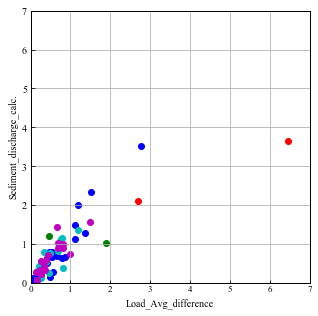

In [58]:
%matplotlib inline
print(temp[-1])
print(W_ans[-1])
W_ans[-1][0]
plt.figure(figsize=(5,5))
for i in range(5):
    Y = df_event_num[i]['Load_Avg_difference'].values.reshape(len(df_event_num[i]['Load_Avg_difference']),1)
    X = df_event_num[i][names_of_data_type]
    Z = np.dot(X, W_ans[-1][1].reshape(1,9).T)
    plt.scatter(Y, Z, color=event_color_2018[i])
    plt.xlim(0,7)
    plt.ylim(0,7)
    plt.xlabel('Load_Avg_difference')
    plt.ylabel('Sediment_discharge_calc.')
    print(np.sum(Y), np.sum(Z))
    

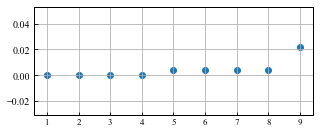

In [59]:
plt.figure(figsize=(5,2))
plt.scatter([1,2,3,4,5,6,7,8,9], W_ans[-1][1])
# plt.ylim(0, 0.5)

## ピット内満砂率と捕捉率の関係を調べ、ソルバー

In [96]:
#使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"
# 目的関数
def func(W):
    c = W[0]
    b = W[1]
    a = W[2]
    df_Rc = c - b*np.exp(df_12345['Load_Avg'])
    df_Qs = df_12345['Load_Avg_difference'] / df_Rc
    df_Qs = df_Qs.values.reshape(len(df_Qs),1)
    print(df_Qs.shape)
    Y = df_12345[y_name].values.reshape(len(df_12345[y_name]),1)
    Y = Y*a
    print(Y.shape)
    Cost = sum(np.power(Y-df_Qs,2))
    print(Cost)
    
#     clf = linear_model.LinearRegression(fit_intercept=False)
#     X = df_Qs.values.reshape(-1, 1)
#     Y = df_12345[y_name].values.reshape(-1, 1)
#     clf.fit(X,Y)
#     y_hat = clf.predict(X)
#     # 近似直線との誤差を計算する
#     diff = Y - y_hat
#     # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
#     sample_weight = (np.max(np.abs(diff)) - np.abs(diff)).astype('float32').T[0] ** 2
#     # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
#     #詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
#     clf.fit(X, Y, sample_weight=sample_weight)
    
#     Cost = -clf.score(X, Y)
    return Cost[0]/100000

cons = ({'type': 'ineq', 'fun': lambda W: W[0]},
        {'type': 'ineq', 'fun': lambda W: W[1]},
        {'type': 'ineq', 'fun': lambda W: W[2]-0.01}
       )

times_of_try = 100
minmum_cost = 100000
temp = []
W_ans = []
results = []
for i in range(times_of_try):
    W0 = np.random.rand(1,3)# 初期値は適当
    result = minimize(func, x0=W0, constraints=cons, method="SLSQP")
    if result.fun < minmum_cost:
        minmum_cost = result.fun
        W_ans.append([i, result.x])
        temp.append([i, minmum_cost])
        results.append([i, result])
    

(89, 1)
(89, 1)
[122704.08111454]
(89, 1)
(89, 1)
[122704.08111454]
(89, 1)
(89, 1)
[122704.08111454]
(89, 1)
(89, 1)
[122704.08111454]
(89, 1)
(89, 1)
[122704.08566371]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[3964.15912798]
(89, 1)
(89, 1)
[3964.15912798]
(89, 1)
(89, 1)
[3964.15912798]
(89, 1)
(89, 1)
[3964.15912798]
(89, 1)
(89, 1)
[3964.15994565]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[170557.0045341]
(89, 1)
(89, 1)
[170557.0045341]
(89, 1)
(89, 1)
[170557.0045341]
(89, 1)
(89, 1)
[170557.0045341]
(89, 1)
(89, 1)
[170557.00989747]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[50764.29984401]
(89, 1)
(89, 1)
[5076

(89, 1)
(89, 1)
[12778.11316077]
(89, 1)
(89, 1)
[12778.11316077]
(89, 1)
(89, 1)
[12778.11316077]
(89, 1)
(89, 1)
[12778.1146288]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[26677.80955783]
(89, 1)
(89, 1)
[26677.80955783]
(89, 1)
(89, 1)
[26677.80955783]
(89, 1)
(89, 1)
[26677.80955783]
(89, 1)
(89, 1)
[26677.81167901]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[9293.07787367]
(89, 1)
(89, 1)
[9293.07787367]
(89, 1)
(89, 1)
[9293.07787367]
(89, 1)
(89, 1)
[9293.07787367]
(89, 1)
(89, 1)
[9293.0791256]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[40729.67825526]
(89, 1)
(89, 1)
[40729.67825526]
(89, 1)
(89, 1)
[40729.678255

(89, 1)
[34105.56492443]
(89, 1)
(89, 1)
[34105.5673228]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[161833.54585047]
(89, 1)
(89, 1)
[161833.54585047]
(89, 1)
(89, 1)
[161833.54585047]
(89, 1)
(89, 1)
[161833.54585047]
(89, 1)
(89, 1)
[161833.55107487]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[13960.79441315]
(89, 1)
(89, 1)
[13960.79441315]
(89, 1)
(89, 1)
[13960.79441315]
(89, 1)
(89, 1)
[13960.79441315]
(89, 1)
(89, 1)
[13960.79594762]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[89490.36933765]
(89, 1)
(89, 1)
[89490.36933765]
(89, 1)
(89, 1)
[89490.36933765]
(89, 1)
(89, 1)
[89490.36933765]
(89, 1)
(89, 1)
[89490.373

[18.98916926]
(89, 1)
(89, 1)
[126308.59983216]
(89, 1)
(89, 1)
[126308.59983216]
(89, 1)
(89, 1)
[126308.59983216]
(89, 1)
(89, 1)
[126308.59983216]
(89, 1)
(89, 1)
[126308.60444766]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[179.36681627]
(89, 1)
(89, 1)
[179.36681627]
(89, 1)
(89, 1)
[179.36681627]
(89, 1)
(89, 1)
[179.36681627]
(89, 1)
(89, 1)
[179.3669902]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[20540.83442361]
(89, 1)
(89, 1)
[20540.83442361]
(89, 1)
(89, 1)
[20540.83442361]
(89, 1)
(89, 1)
[20540.83442361]
(89, 1)
(89, 1)
[20540.83628489]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98911267]
(89, 1)
(89, 1)
[18.98916926]
(89, 1)
(89, 1)
[56591.64683598]
(89, 1)
(89, 1

In [97]:
W_ans[-1]
print(results[-1])

[16,      fun: 0.00018989112666638867
     jac: array([0.        , 0.        , 0.03797825])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.94825972, 0.16731856, 0.01      ])]


In [98]:
W = results[-1][1].x
c = W[0]
b = W[1]
df_Rc = c - b*np.exp(df_12345['Load_Avg'])
df_Qs = df_12345['Load_Avg_difference'] / df_Rc

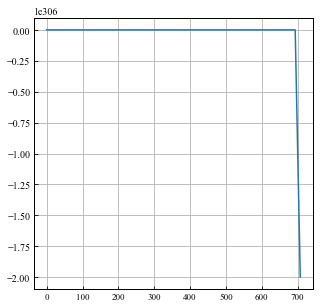

0.9482597176433213 0.16731856246619214
[ 7.80941155e-001 -2.31782411e+005 -3.21085269e+011 -4.44793578e+017
 -6.16164448e+023 -8.53561394e+029 -1.18242306e+036 -1.63798915e+042
 -2.26907655e+048 -3.14331045e+054 -4.35437075e+060 -6.03203054e+066
 -8.35606212e+072 -1.15755008e+079 -1.60353305e+085 -2.22134515e+091
 -3.07718900e+097 -4.26277391e+103 -5.90514311e+109 -8.18028727e+115
 -1.13320031e+122 -1.56980176e+128 -2.17461780e+134 -3.01245846e+140
 -4.17310387e+146 -5.78092484e+152 -8.00820995e+158 -1.10936275e+165
 -1.53678002e+171 -2.12887339e+177 -2.94908956e+183 -4.08532010e+189
 -5.65931957e+195 -7.83975239e+201 -1.08602663e+208 -1.50445292e+214
 -2.08409125e+220 -2.88705367e+226 -3.99938290e+232 -5.54027234e+238
 -7.67483843e+244 -1.06318140e+251 -1.47280584e+257 -2.04025112e+263
 -2.82632274e+269 -3.91525345e+275 -5.42372934e+281 -7.51339354e+287
 -1.04081673e+294 -1.44182447e+300 -1.99733320e+306             -inf
             -inf             -inf             -inf             

In [99]:
plt.figure(figsize=(5,5))
x = np.linspace(0, 1400, 100)
y = c-b * (np.exp(x))
plt.plot(x, y)
plt.show()
print(c,b)
print(y)

In [ ]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.scatter(df_Qs, df_12345[y_name])

In [ ]:
def scatter_graph_in_df(df, x_name, y_name, x_range=(-2,20), y_range=(-1,7.5)):
    '''
    df :　DetaFrame
    x_name：ｘ軸に用いるパラメータの名前(str)
    y_name：ｙ軸に用いるパラメータの名前(str)
    '''
    # 「散布図行列」を作成する。散布図行列を利用すれば、データセットの特徴量のペアに対す
    # る相関関係を1 つの平面上で可視化可能
    # Notebook出力には次の１行が必要
    a, b = x_range
    c, d = y_range
    %matplotlib inline
    # Plot the data you select
    plt.figure(figsize=(8, 6))

    plt.scatter(df[x_name], df[y_name])
    plt.xlim(a, b)
    plt.ylim(c, d)

    plt.show()    

In [ ]:
scatter_graph_in_df(df_cut_from000to200, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from200to400, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from400to600, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from600to800, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from800to1000, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1000to1200, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1200to1400, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1400to1600, 'Load_Avg_difference', 'hp_Tot(4)')


In [ ]:
histgram_of_Load_Avg_difference(df_mean_30)

In [ ]:
pd.options.display.max_seq_items = 200

print(df_fin.columns)

pd.options.display.max_seq_items = 20

In [ ]:
#Choose data we are gonna use
#YOU SHOULD CHANGE HERE IF YOU WANNA SELECT DIFFERENT INPUT DATA OR ADD SOME DATA AS INPUTS
# y_cols = ['Load_Avg_difference']
y_cols = ['Load_Avg_difference']

#ALL
X_cols = ['Bat_Avg', 'WL_FMR_Avg', 'vel_P_Tot',
       'turb1000_Avg', 'turb4000_Avg', 'DiffVolt_Avg', 'hp_Tot(1)',
       'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)',
       'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'outC_R_Avg', 'R_Tot(1)', 'R_Tot(2)', 'R_Tot(3)',
       'R_Tot(4)', 'R_Tot(5)', 'R_Tot(6)', 'R_Tot(7)', 'R_Tot(8)', 'R_Tot(9)',
       'R_Tot(10)', 'outC_RC_Avg', 'RC_Tot(1)', 'RC_Tot(2)', 'RC_Tot(3)',
       'RC_Tot(4)', 'RC_Tot(5)', 'RC_Tot(6)', 'RC_Tot(7)', 'RC_Tot(8)',
       'RC_Tot(9)', 'RC_Tot(10)', 'outC_C_Avg', 'C_Tot(1)', 'C_Tot(2)',
       'C_Tot(3)', 'C_Tot(4)', 'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)',
       'C_Tot(9)', 'C_Tot(10)', 'outC_LC_Avg', 'LC_Tot(1)', 'LC_Tot(2)',
       'LC_Tot(3)', 'LC_Tot(4)', 'LC_Tot(5)', 'LC_Tot(6)', 'LC_Tot(7)',
       'LC_Tot(8)', 'LC_Tot(9)', 'LC_Tot(10)', 'outC_L_Avg', 'L_Tot(1)',
       'L_Tot(2)', 'L_Tot(3)', 'L_Tot(4)', 'L_Tot(5)', 'L_Tot(6)', 'L_Tot(7)',
       'L_Tot(8)', 'L_Tot(9)', 'L_Tot(10)', 'outC_VR_Avg', 'VR_Tot(1)',
       'VR_Tot(2)', 'VR_Tot(3)', 'VR_Tot(4)', 'VR_Tot(5)', 'VR_Tot(6)',
       'VR_Tot(7)', 'VR_Tot(8)', 'VR_Tot(9)', 'VR_Tot(10)', 'outC_VL_Avg',
       'VL_Tot(1)', 'VL_Tot(2)', 'VL_Tot(3)', 'VL_Tot(4)', 'VL_Tot(5)',
       'VL_Tot(6)', 'VL_Tot(7)', 'VL_Tot(8)', 'VL_Tot(9)', 'VL_Tot(10)',
       'outC_VC_Avg', 'VC_Tot(1)', 'VC_Tot(2)', 'VC_Tot(3)', 'VC_Tot(4)',
       'VC_Tot(5)', 'VC_Tot(6)', 'VC_Tot(7)', 'VC_Tot(8)', 'VC_Tot(9)',
       'VC_Tot(10)', 'outC_T75_Avg', 'T75_Tot(1)', 'T75_Tot(2)', 'T75_Tot(3)',
       'T75_Tot(4)', 'T75_Tot(5)', 'T75_Tot(6)', 'T75_Tot(7)', 'T75_Tot(8)',
       'T75_Tot(9)', 'T75_Tot(10)', 'outC_Plate_Avg', 'Plate_Tot(1)',
       'Plate_Tot(2)', 'Plate_Tot(3)', 'Plate_Tot(4)', 'Plate_Tot(5)',
       'Plate_Tot(6)', 'Plate_Tot(7)', 'Plate_Tot(8)', 'Plate_Tot(9)',
       'Plate_Tot(10)', 'Vib_Avg']

X = df_fin[X_cols]
y = df_fin[y_cols]
# #     X.rolling(window=5).mean()
#     y.rolling(window=5).mean()



In [ ]:
# print(X)

In [ ]:
#Cut data where pit weigh < 1000?500?
df_fin['Load_Avg'] = df_fin['Load_Avg'].values.astype('float')
df_cut1 = df_fin[(df_fin['Load_Avg'] > 200)&(df_fin['Load_Avg'] < 1300)]

# Cut data where pit load difference is out of margin of error
df_cut2 = df_cut1[(df_cut1['Load_Avg_difference'] < 20)&(df_cut1['Load_Avg_difference'] > -0.5)]

In [ ]:
# 「散布図行列」を作成する。散布図行列を利用すれば、データセットの特徴量のペアに対す
# る相関関係を1 つの平面上で可視化可能
import matplotlib.pyplot as plt
import seaborn as sns
Xy_cols = X_cols + y_cols
df_f = df_cut2[Xy_cols].astype('float')
sns.pairplot(df_f[Xy_cols],x_vars=['Load_Avg_difference'], y_vars= Xy_cols, height=2.5)

#グラフを保存するときは描画させない
plt.show()
# plt.savefig('figure(LADandOthers).png')

In [ ]:
# df_cut3 = df_cut2.set_index('TIMESTAMP')

fig, ax1 = plt.subplots()

#x軸
s=df_cut2.index

#主軸に出来高の棒グラフ
ax1.bar(s,df_cut2['hp_Tot(1)'], color = 'g')

#主軸と2軸の関連づけ
ax2=ax1.twinx()

#第2軸に株価
ax2.plot(s,df_cut2['Rainfall'],'r', label = 'pulses')

# 描画の調整
plt.rcParams['font.size'] = 8
plt.ylabel('Number_of_pulses')
plt.legend()
plt.savefig('compiration_LADandHP(1).png')
plt.show()

In [ ]:
X = df_cut2[X_cols].values.astype('float')
y = df_cut2[y_cols].values.astype('float')

In [ ]:
#Devide data into Training set and test set
#In Machine Learning course of coursera, I learned that I have to devide the data set into Training set, Cross calidation set,Test set.
#But in this case I'll just follow the code that I found online. Probably I'll have to fix this part once I get to know much more about Machine Learning.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_ori_train = X_train
X_ori_test = X_test
y_ori_train = y_train
y_ori_test = y_test

In [ ]:
# train the parameters with regression model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(100)
# n_estimators : integer, optional (default=10)
# The number of trees in the forest.

model.fit(X_train, y_train.ravel())

In [ ]:
#Score
#coefficient of determination R^2 

print(model.score(X_test,y_test))

In [ ]:
# #Score without the data where there's no events happning
#Delete data of when the pit gets cleared 

df_y_test = pd.DataFrame(y_test)
df_y_test.columns = y_cols
df_X_test = pd.DataFrame(X_test)
df_X_test.columns = X_cols

df_yX_test = pd.concat([df_y_test, df_X_test], axis=1)

df_yX_test_del = df_yX_test[(df_yX_test['Load_Avg_difference'] < 20)&(df_yX_test['Load_Avg_difference'] > 1)]
X_test_del = df_yX_test_del[X_cols].values.astype('float')
y_test_del = df_yX_test_del[y_cols].values.astype('float')


print("Score ,when y>1")
print(model.score(X_test_del,y_test_del))
print("The number of the data where y > 1 ", "is " ,len(y_test_del))

In [ ]:
# y, X should be real data. X is gonna put into the model you made 
# and the model will give you the predictions. 
# This line graph shows how the predicitons match with the real data which is y.
# Second gragh zooms out the part where you chose from sta to end.
class Graph:
    def __init__(self, y, X):
        self.y = y
        self.X = X
        

    def line_graph(self, sta = 0, end = len(y)):
        result = model.predict(self.X)
        #flatten y_test to applay the data to a graph
        y_graph = self.y.flatten()
        #
        df_result = pd.DataFrame({"y_test":y_graph,"result":result})

        #
        %matplotlib inline
        import matplotlib
        import matplotlib.pyplot as plt

        # Draw graph
        df_result.plot(figsize=(15, 3))
        
        # Zoom out where you chose
        df_result[sta:end].plot(figsize=(15, 3))
        plt.show()
        
    def cumlate_graph(self, sta = 0, end = len(y)):
        result = model.predict(self.X)

        p_res = np.cumsum(result)
        y_res = np.cumsum(self.y)

        %matplotlib inline
        import matplotlib
        import matplotlib.pyplot as plt

        df_p_x = pd.DataFrame({"original":y_res,"result":p_res})
        df_p_x.plot(figsize=(15, 3))
        df_p_x[sta:end].plot(figsize=(15, 3))
        plt.show()

        
    #Take a look at a distribution map between y and X
    def distribution_map(self, number = 0):
        import matplotlib.pyplot as plt
        # Notebook出力には次の１行が必要
        %matplotlib inline

        # # Plot the data you select
        plt.figure(figsize=(8, 6))

        plt.scatter(self.y, self.X[:,number])
        plt.show()

        
    


In [ ]:
# Graphs of test data

yX_test = Graph(y_test,X_test)
yX_test.line_graph()
for i in range(len(X_cols)):
    yX_test.distribution_map(i)
yX_test.cumlate_graph()

In [ ]:
yX_all = Graph(y, X)
yX_all.line_graph()
# yX_all.cumlate_graph(90000,100000)
# for i in range(len(X_cols)):
#     yX_all.distribution_map(i)
#     print(X_cols[i])

In [ ]:
yX_all = Graph(y, X)
yX_all.line_graph()

In [ ]:
yX_test_del = Graph(y_test_del, X_test_del)
yX_test_del.distribution_map(3)
yX_test_del.cumlate_graph()
yX_test_del.line_graph()

In [ ]:
df_ori = df_new[(df_new['hp_Tot(6)'] > -10)&(df_new['hp_Tot(6)'] < 500)]

X_ori = df_ori[X_cols].values.astype('float')
y_ori = df_ori[y_cols].values.astype('float')


yX_ori = Graph(y_ori, X_ori)
yX_ori.cumlate_graph()


In [ ]:
#
feature = model.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.loc[:, 'number']

#Name of the features
dfX = pd.DataFrame(X)
dfX.columns = X_cols
label = dfX.columns[0:]

#arrange the features in order of importance
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print( str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

          
import matplotlib
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.datasets import *
# from sklearn import tree
# from dtreeviz.trees import *
# import graphviz

In [ ]:
# from sklearn.datasets import *
# from sklearn import tree
# from dtreeviz.trees import *

# X_cols_np = np.array(X_cols)

# regr = tree.DecisionTreeRegressor(max_depth=10)
# regr.fit(X_train, y_train.ravel())

# viz = dtreeviz(regr,
#                X_train,
#                y_train.ravel(),
#                target_name="",
#                feature_names= X_cols_np
#               )

# #There's a UnicodeDecodeError problem if you try to visualize "viz",which is caused by the Japanese setting of this computer.
# #"viz.view()" works fine on Ubuntu in my Virtual machine.
# # viz.view()

In [ ]:
# print(regr.score(X_test,y_test))